# Please read the [README](https://github.com/ibudiselic/covid/blob/master/README.md) file in this repository.

In [1]:
# Load all the data and functionality.
%run lib.ipynb

countries_to_plot = ['Croatia', 'Switzerland', 'Italy', 'US', 'United Kingdom', 'Sweden']

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Cross-country comparison over absolute dates

## Confirmed

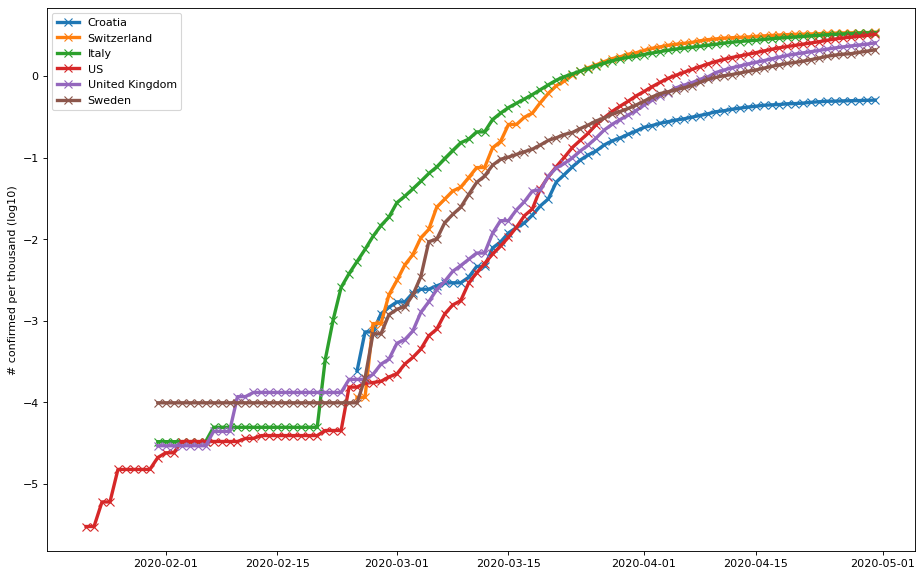

## Dead

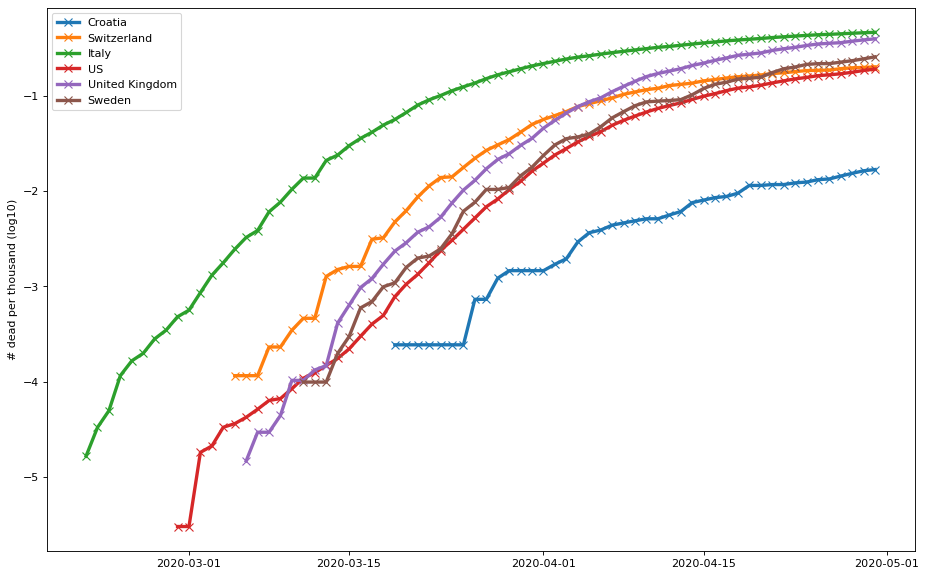

In [3]:
for series in ['confirmed', 'dead']:
    compare_countries_absolute_dates(series)

# Cross-country comparison with approximately aligned start days

## Confirmed

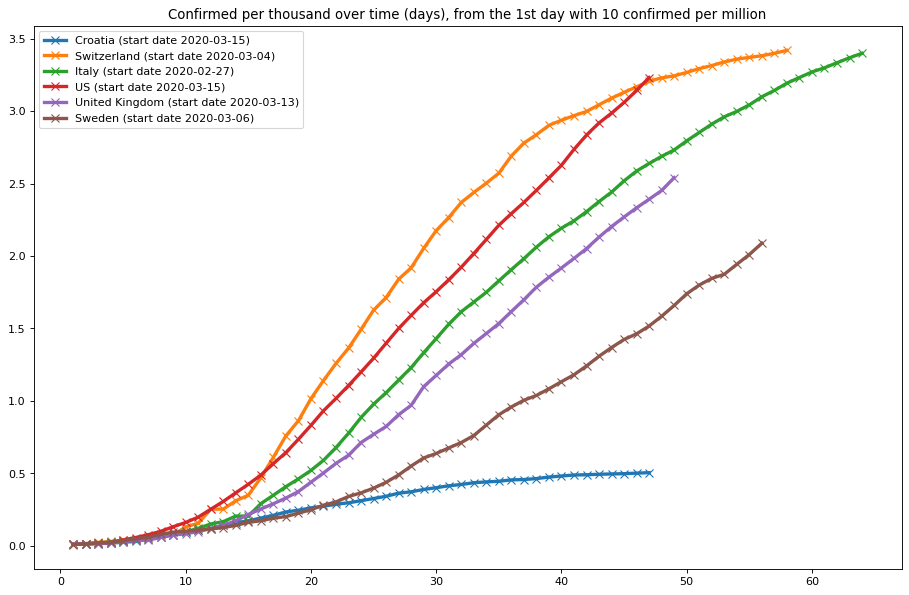

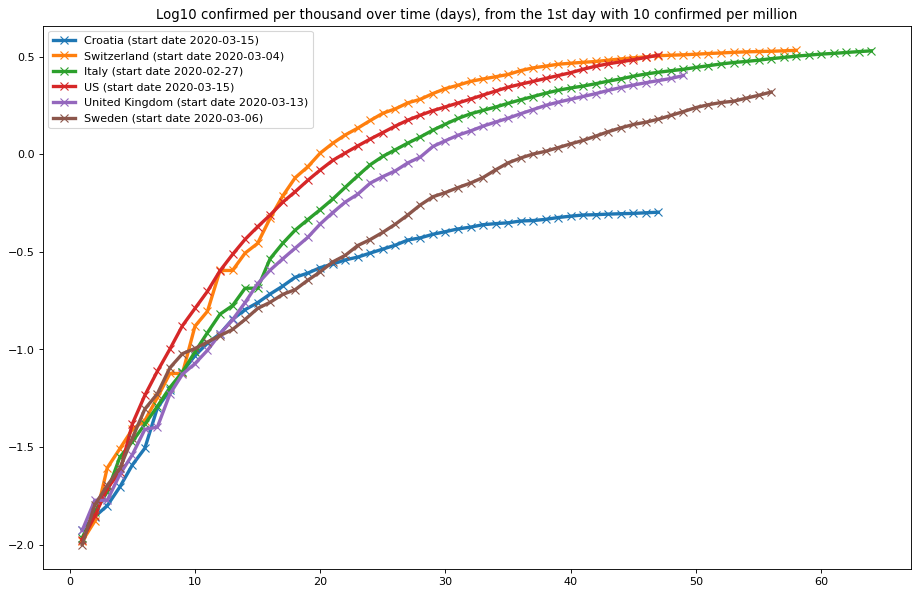

In [4]:
compare_countries_relative_dates('confirmed', start_info=(0.01, '10 confirmed per million'))

## Dead

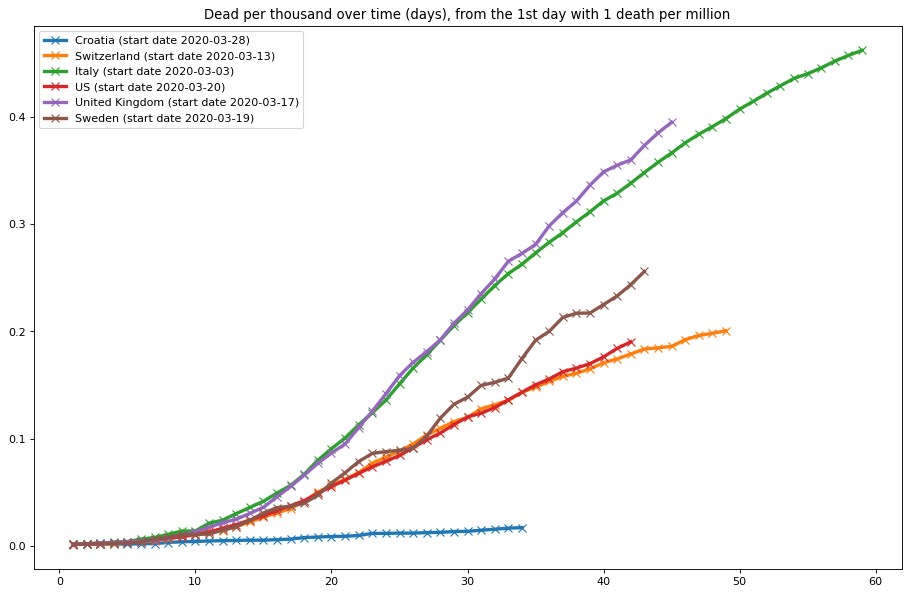

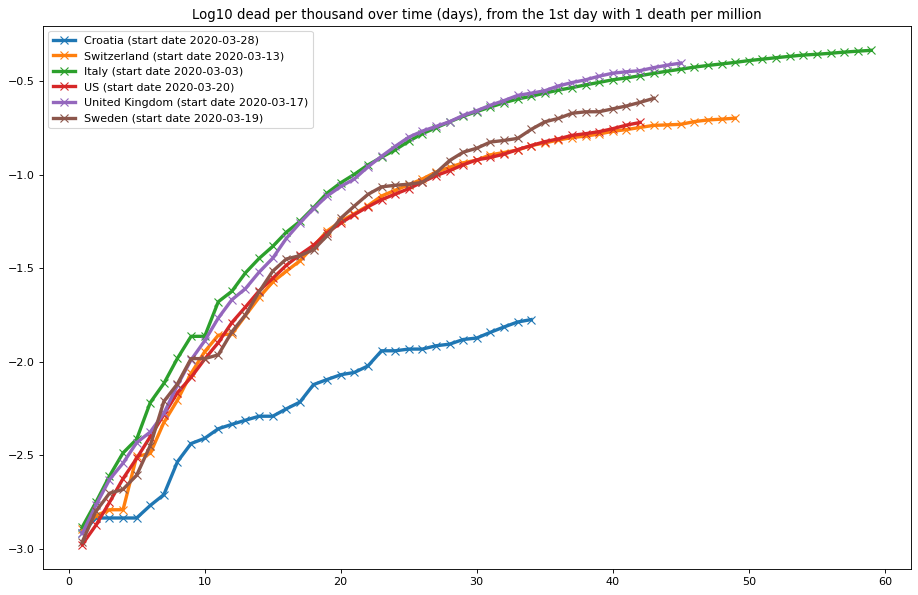

In [5]:
compare_countries_relative_dates('dead', start_info=(0.001, '1 death per million'))

# Per-country analysis with exponential and sigmoidal projections, and new cases analysis

<span style="color:red;">
IMPORTANT: The projections are only accurate if the fit is good (it often isn't), and assuming nothing changes
going forward. The sigmoid is omitted if a reasonable fit can't be computed, but this still doesn't mean that
the fit is good if it is shown.
</span>
                 
The dashed lines show best fit projections from a few previous days for comparison.

## Croatia

Population \\(4,105,267\\)

### Confirmed

Start date 2020-02-28 (1st day with 1 confirmed per million)

Latest number \\(2,076\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

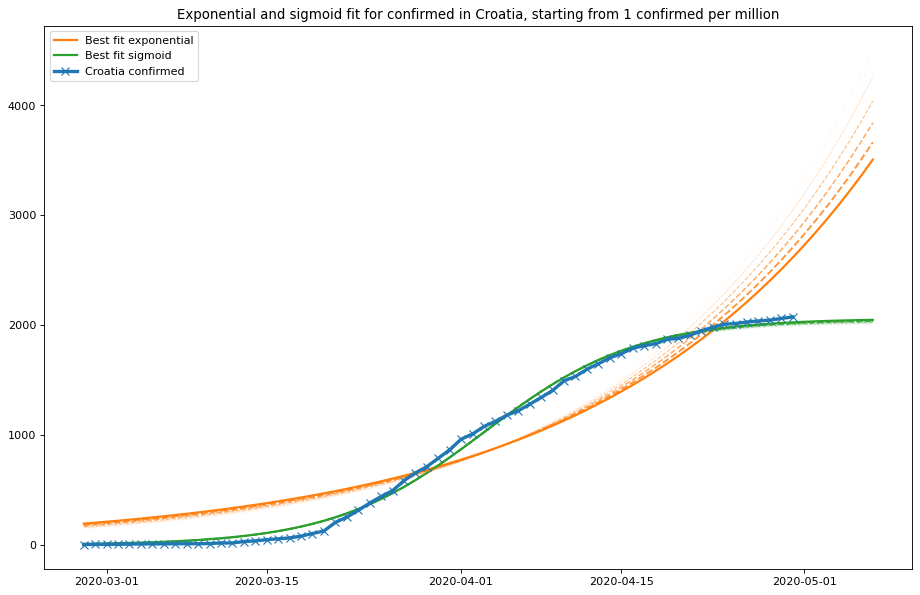

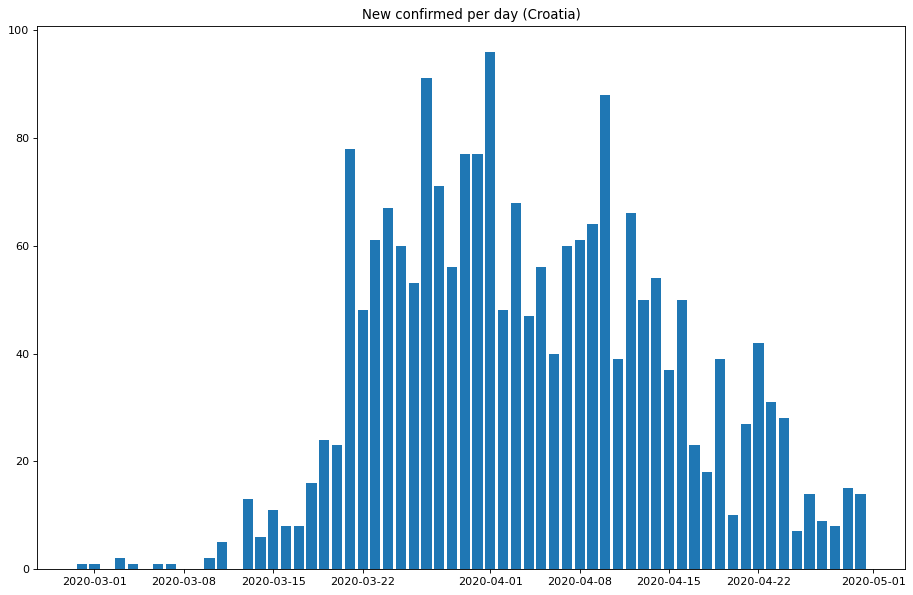

### Dead

Start date 2020-03-19 (1st day with 0.1 dead per million)

Latest number \\(69\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

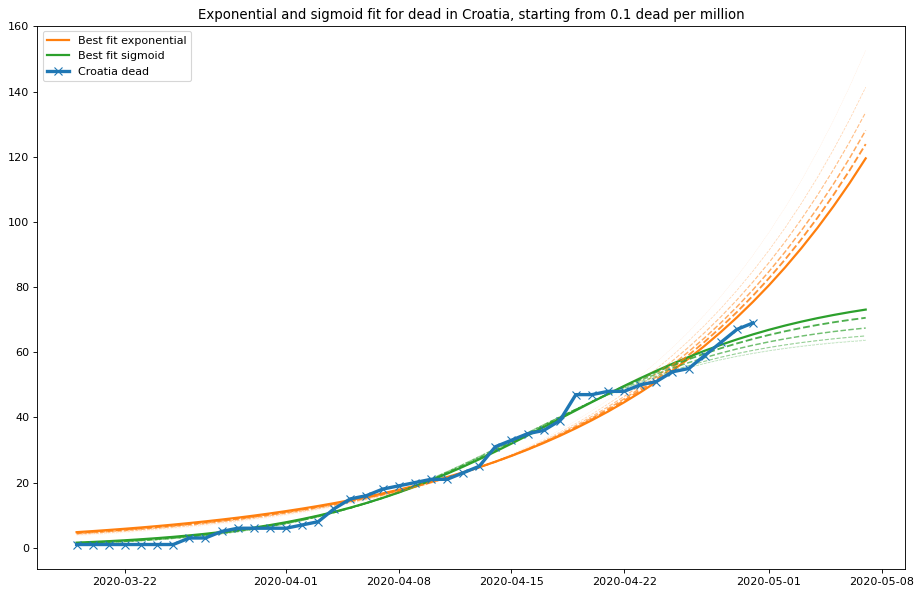

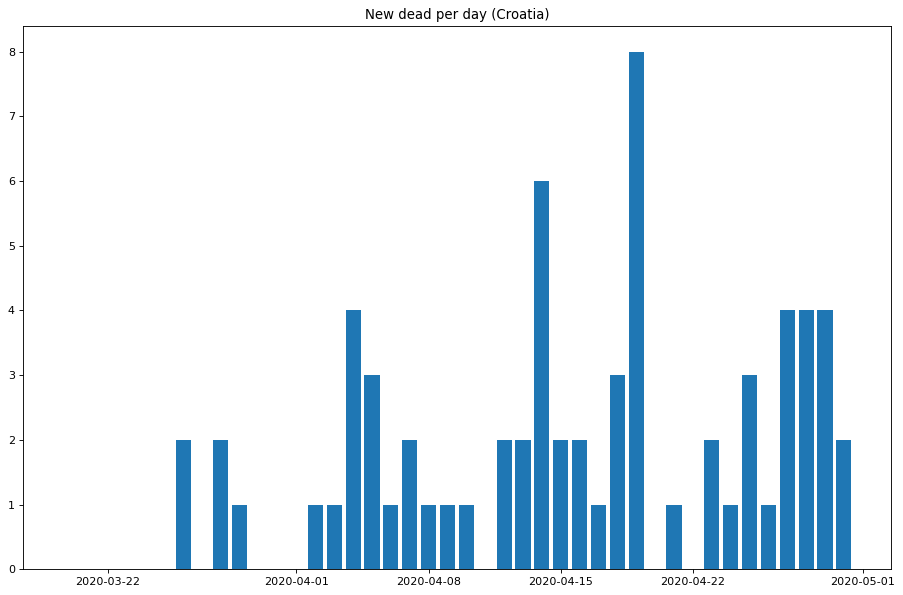

### Active

Start date 2020-02-28 (1st day with 1 active per million)

Latest number \\(659\\) on 2020-04-30

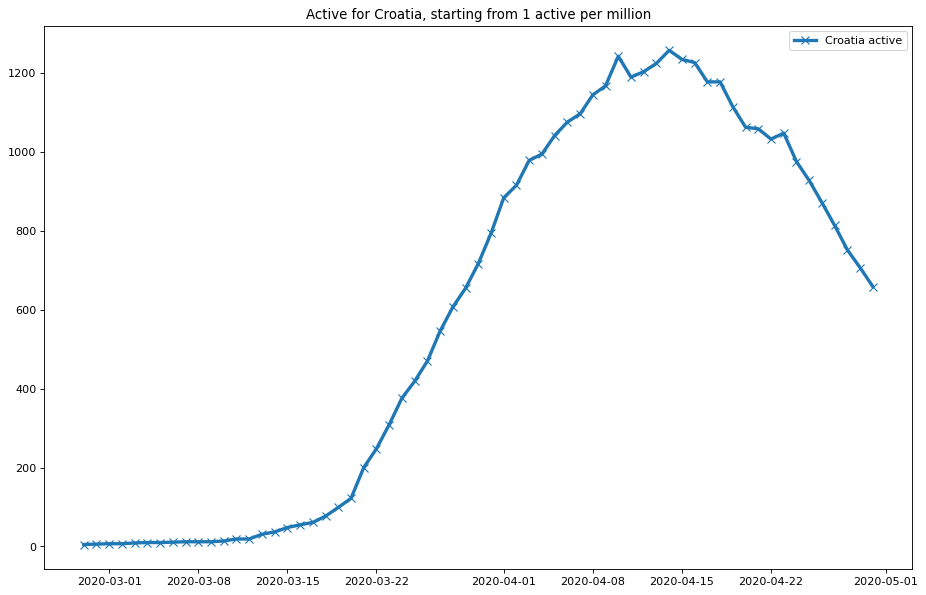

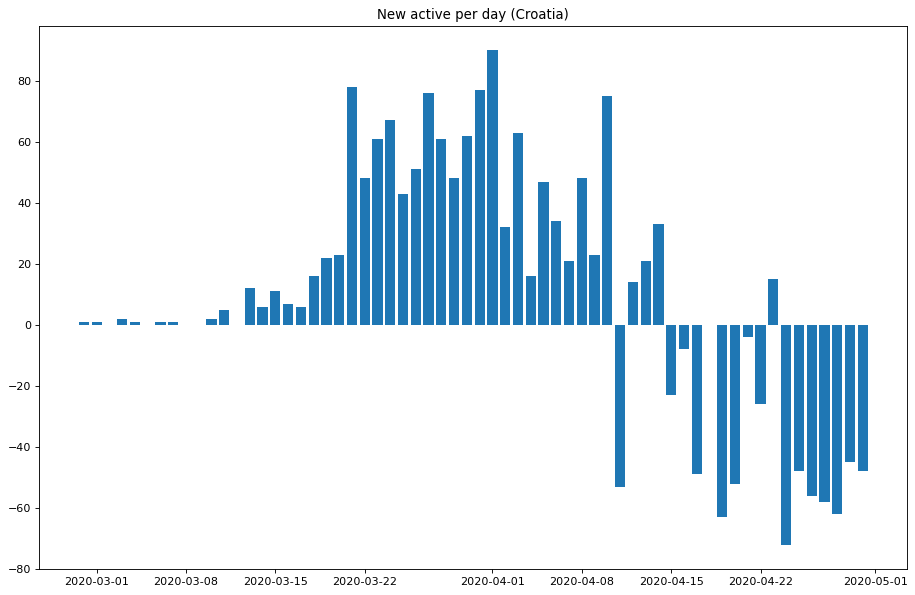

## Switzerland

Population \\(8,654,622\\)

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(29,586\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

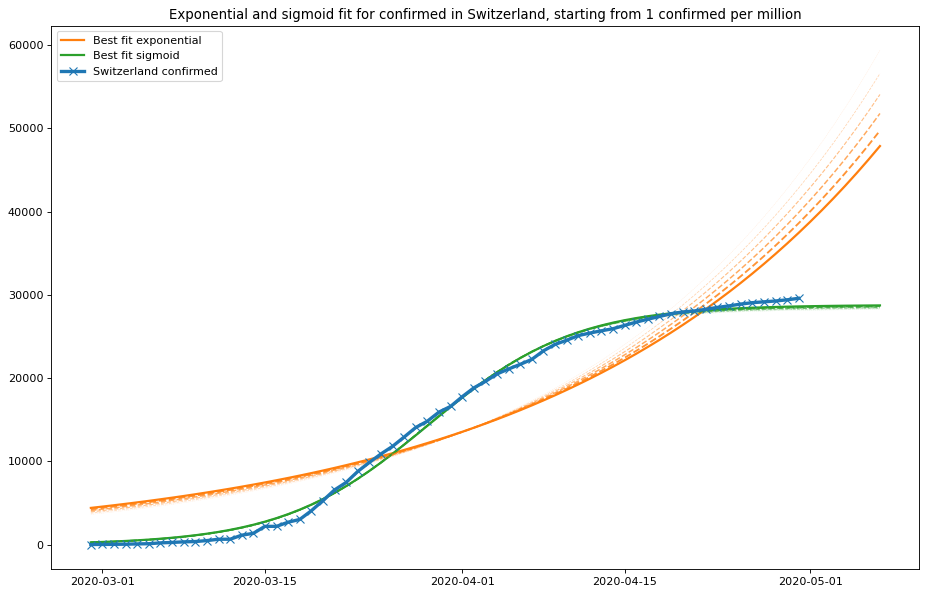

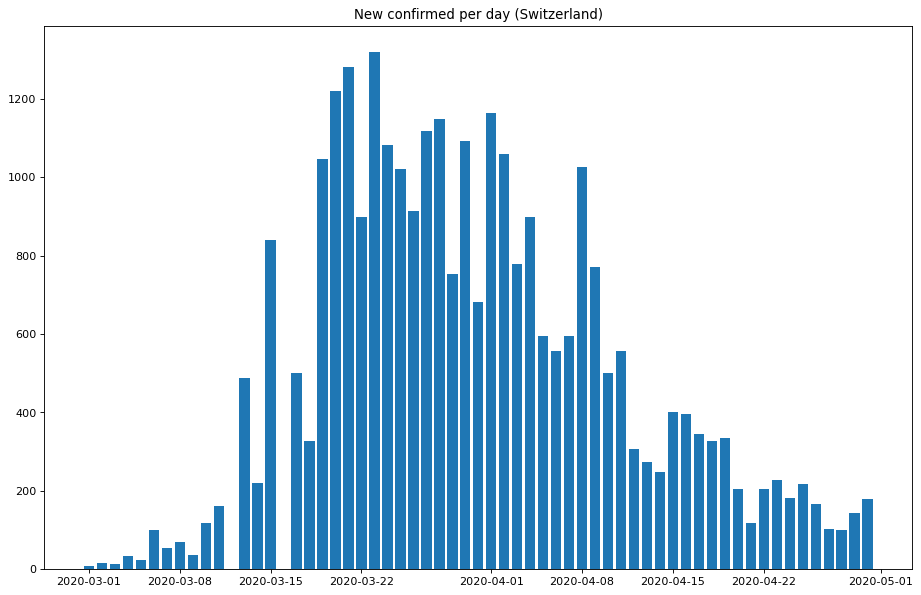

### Dead

Start date 2020-03-05 (1st day with 0.1 dead per million)

Latest number \\(1,737\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

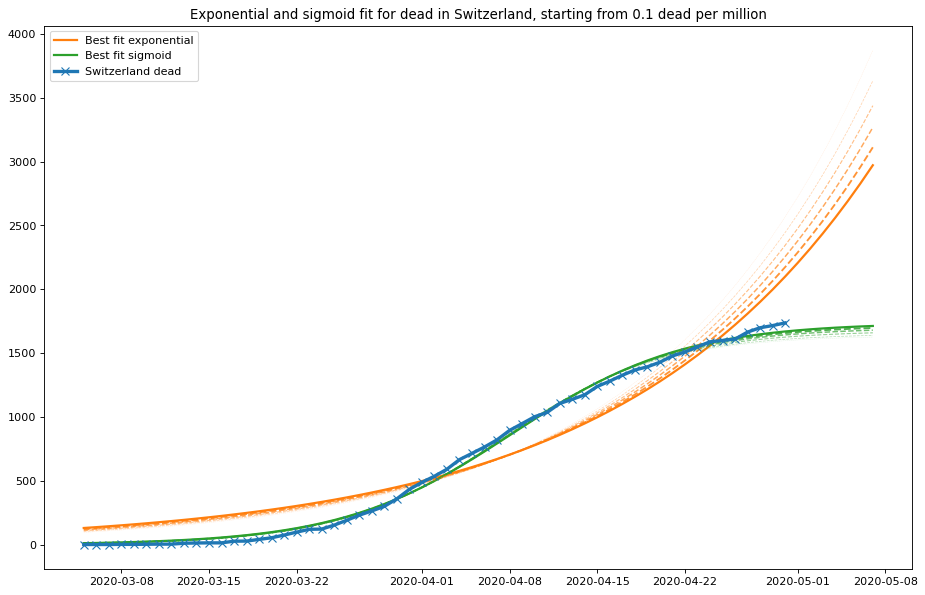

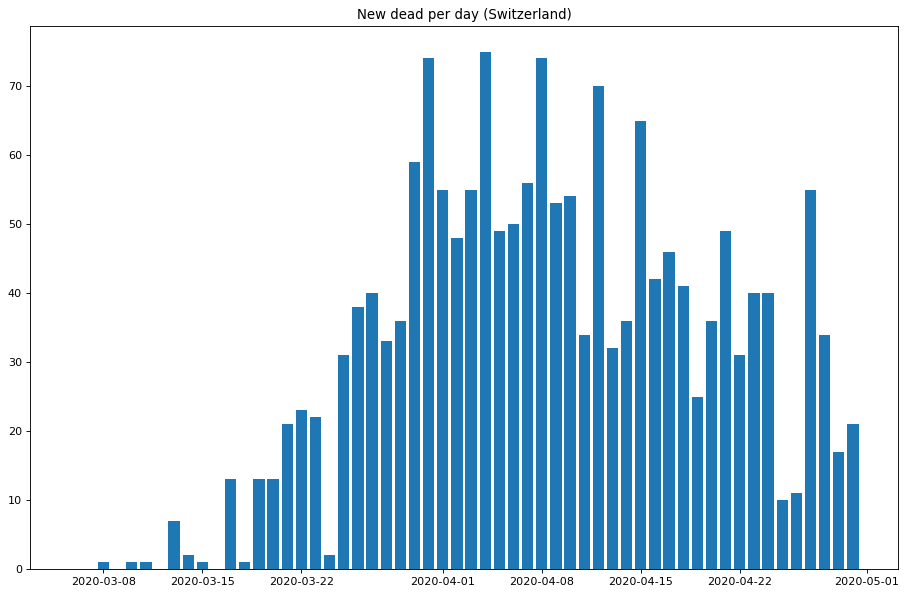

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(4,449\\) on 2020-04-30

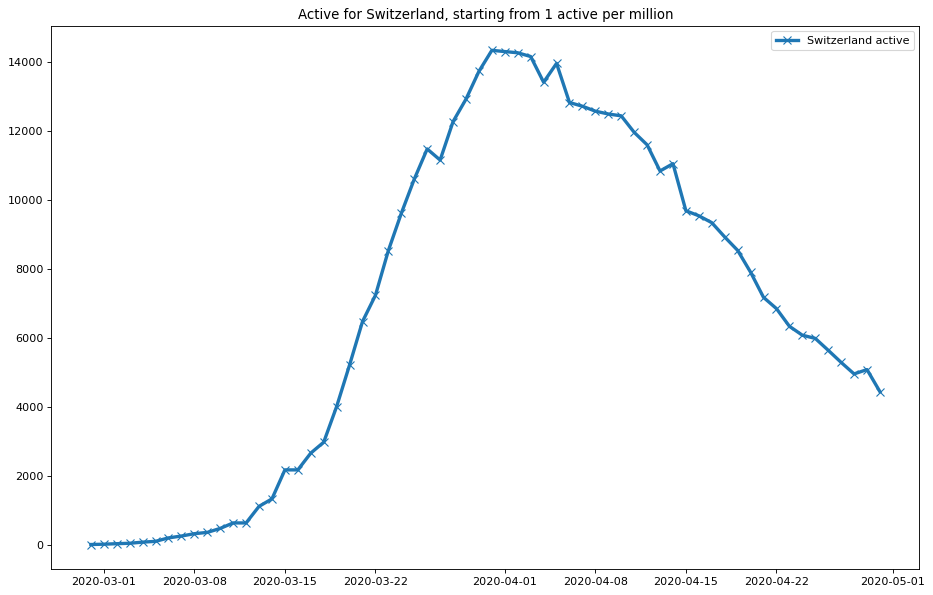

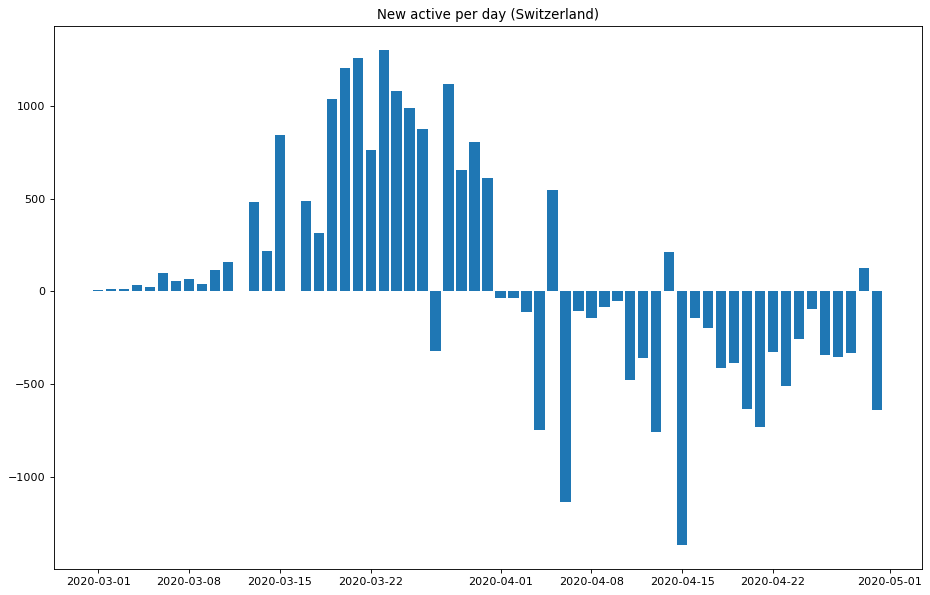

## Italy

Population \\(60,461,826\\)

### Confirmed

Start date 2020-02-22 (1st day with 1 confirmed per million)

Latest number \\(205,463\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

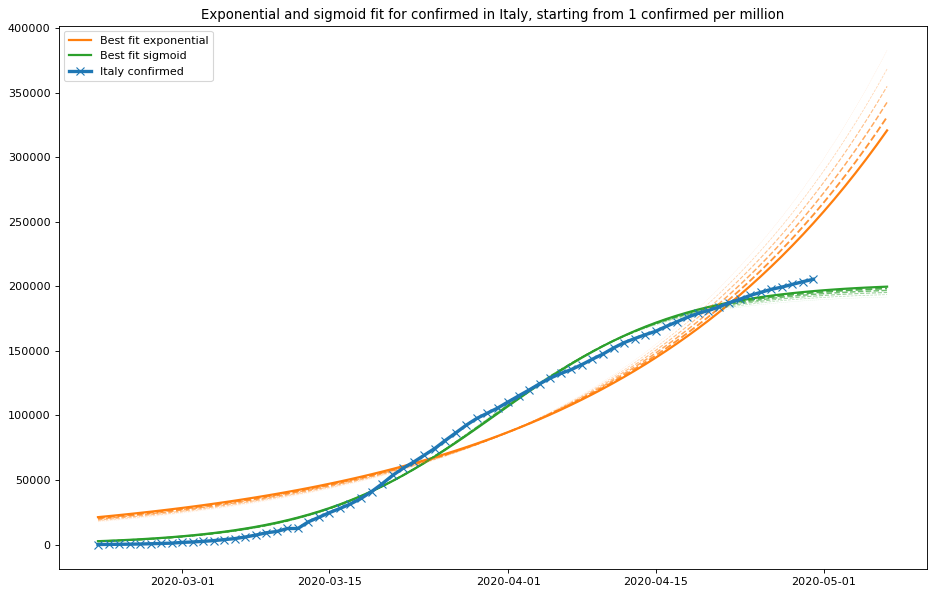

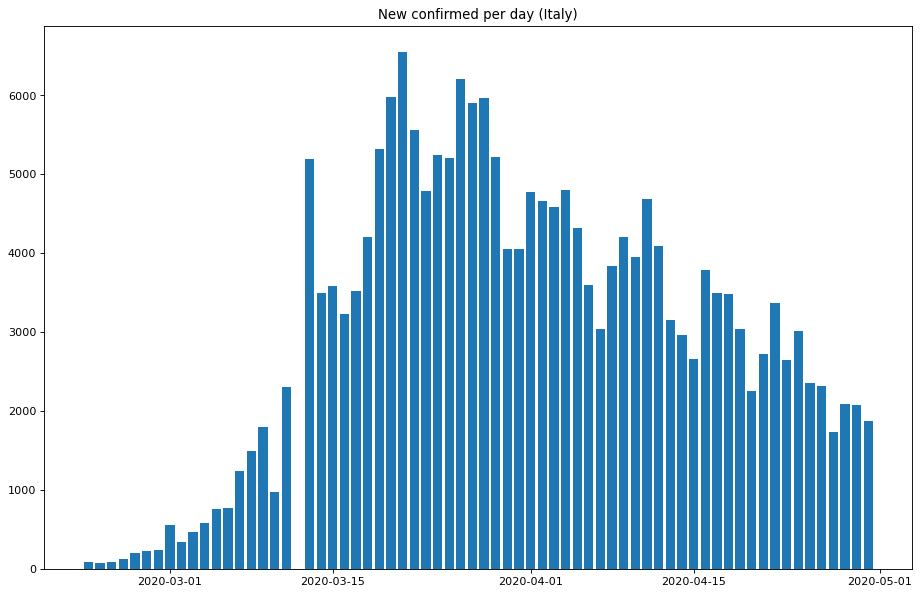

### Dead

Start date 2020-02-24 (1st day with 0.1 dead per million)

Latest number \\(27,967\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

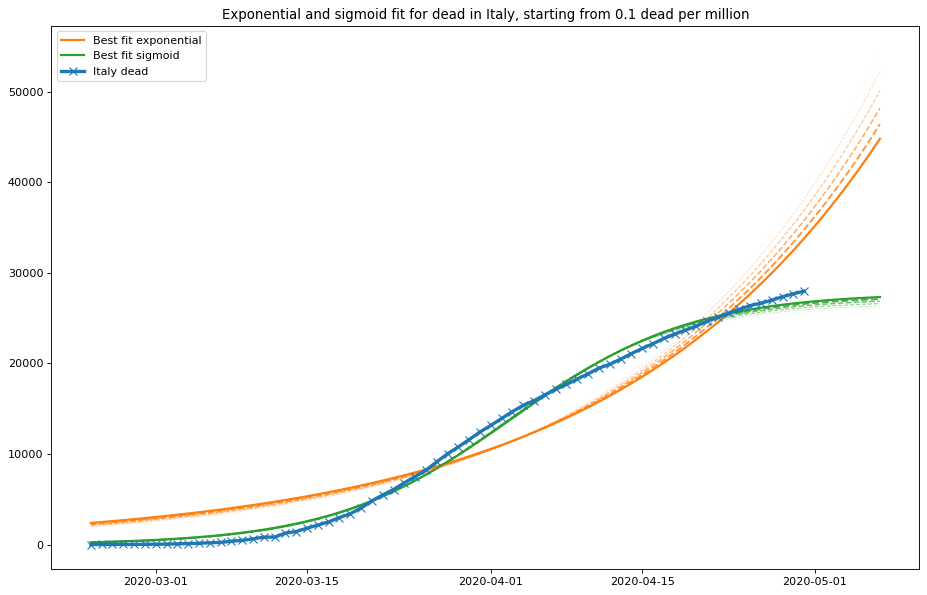

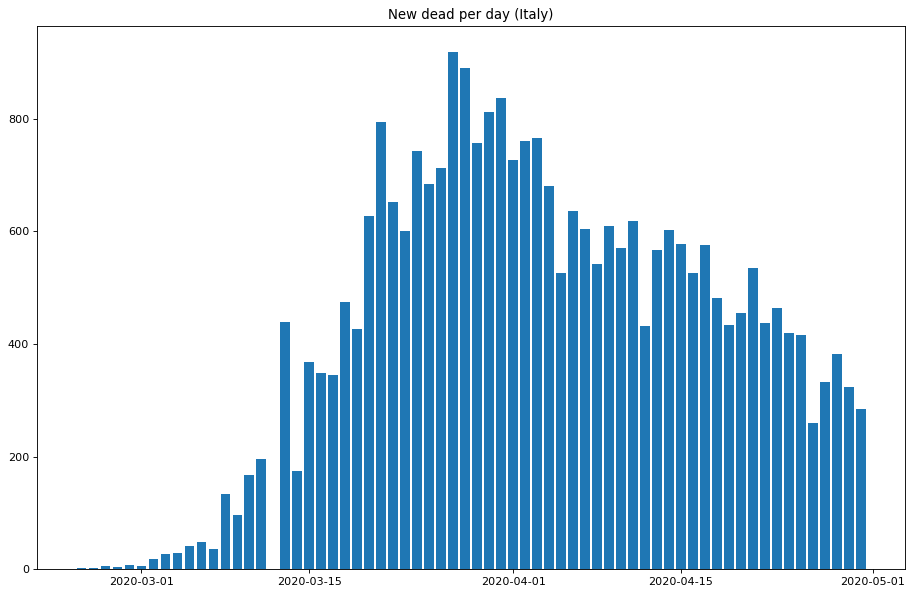

### Active

Start date 2020-02-23 (1st day with 1 active per million)

Latest number \\(101,551\\) on 2020-04-30

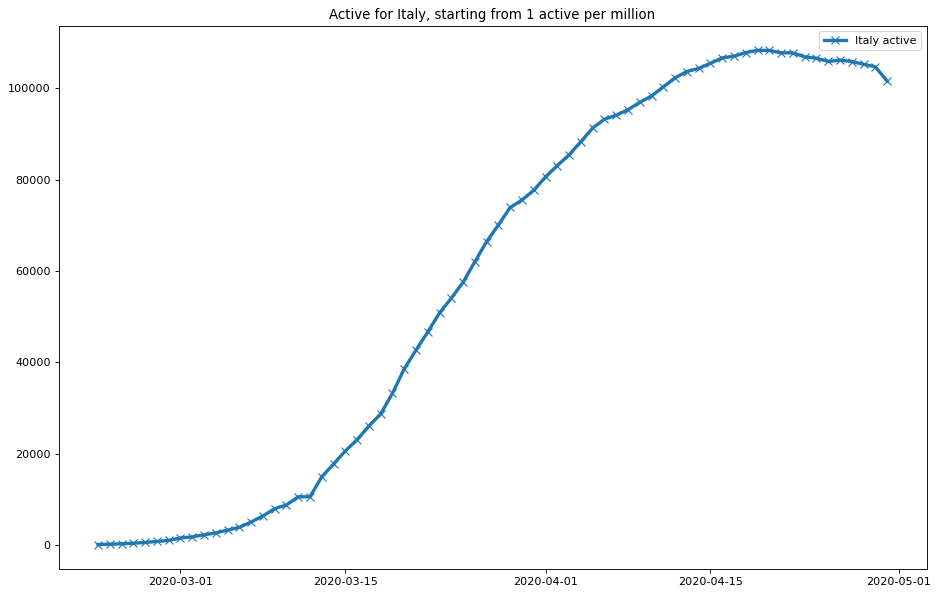

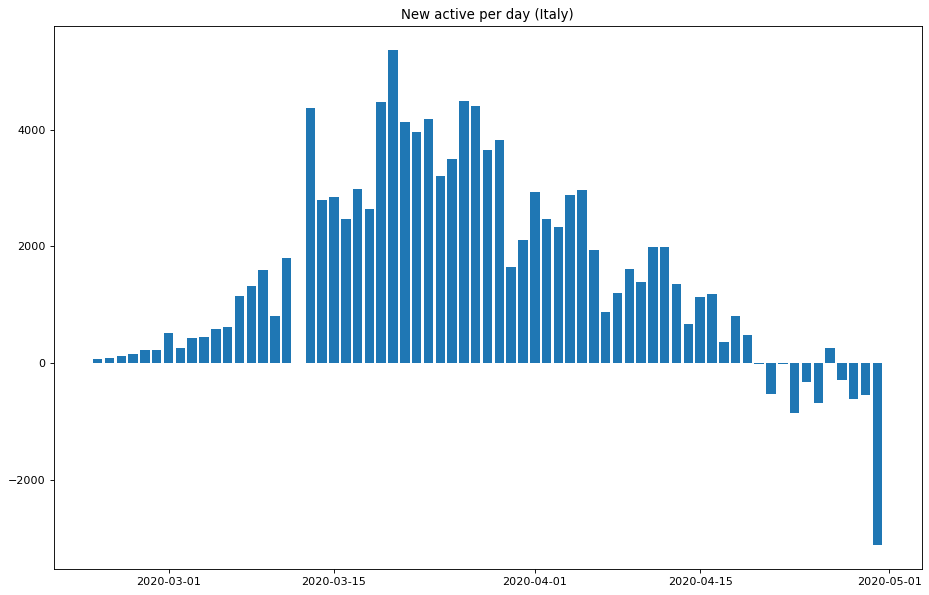

## US

Population \\(331,002,651\\)

### Confirmed

Start date 2020-03-07 (1st day with 1 confirmed per million)

Latest number \\(1,069,424\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

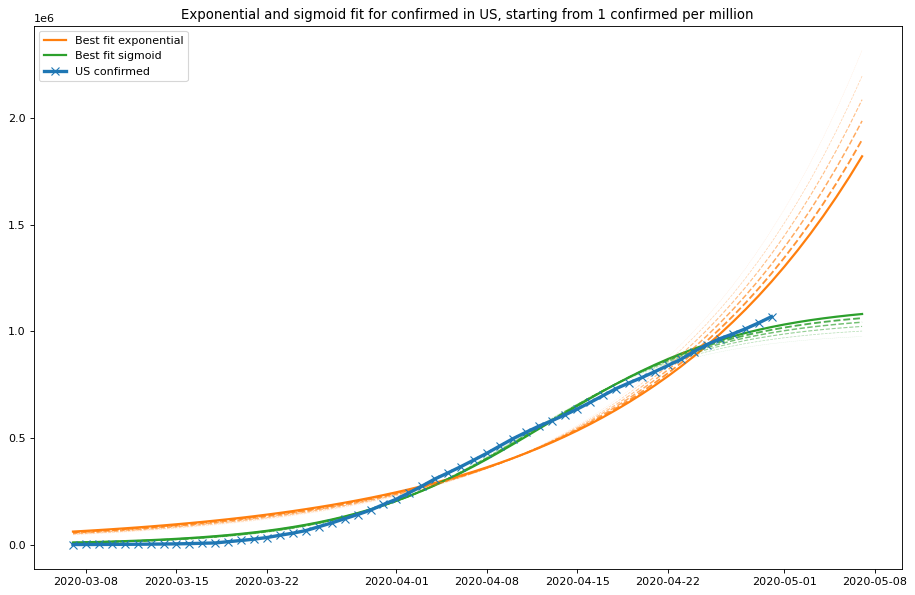

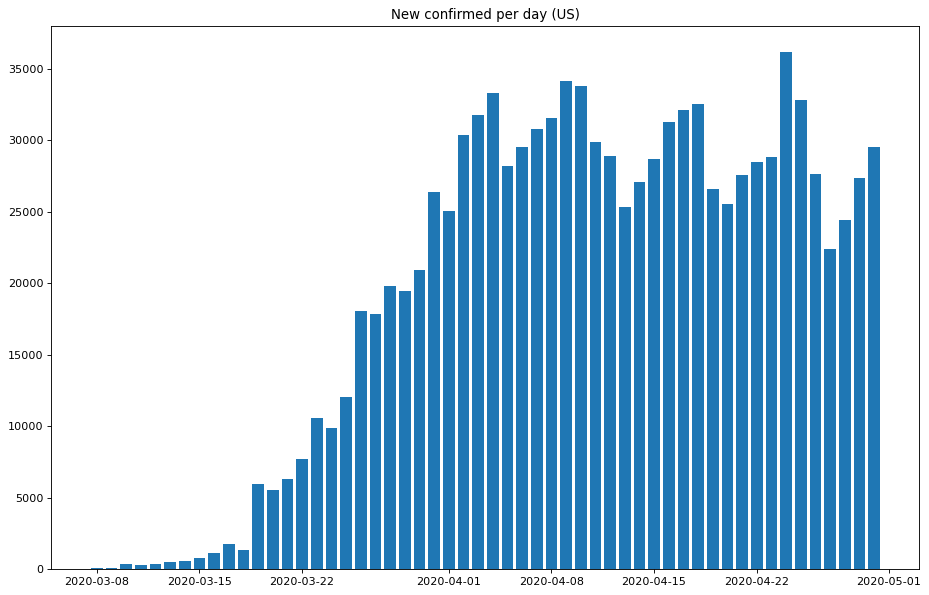

### Dead

Start date 2020-03-11 (1st day with 0.1 dead per million)

Latest number \\(62,996\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

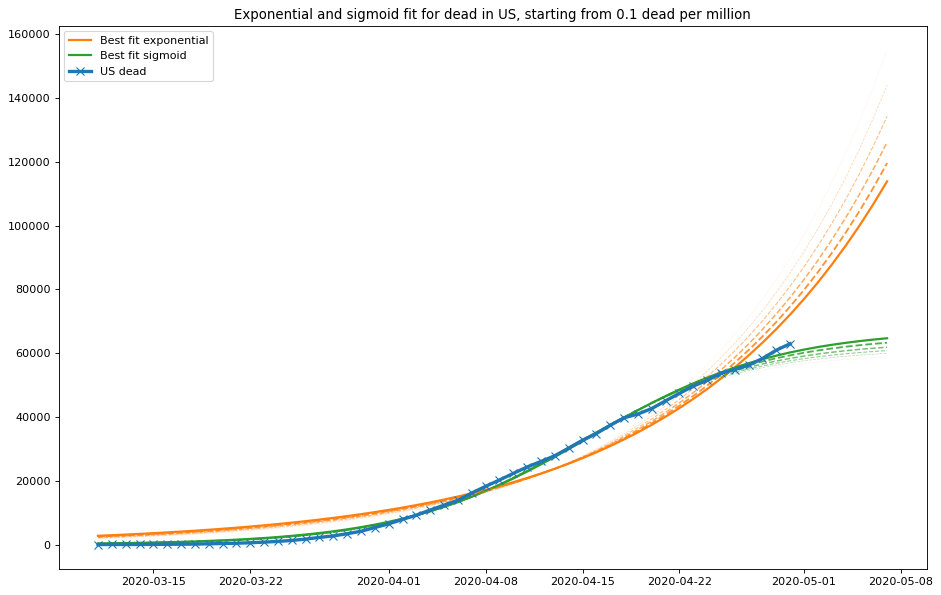

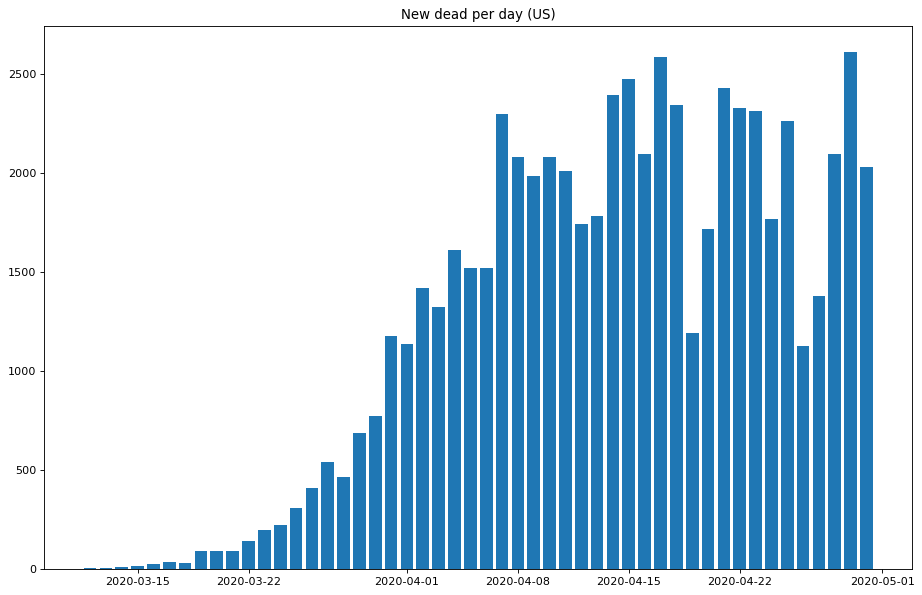

### Active

Start date 2020-03-07 (1st day with 1 active per million)

Latest number \\(852,481\\) on 2020-04-30

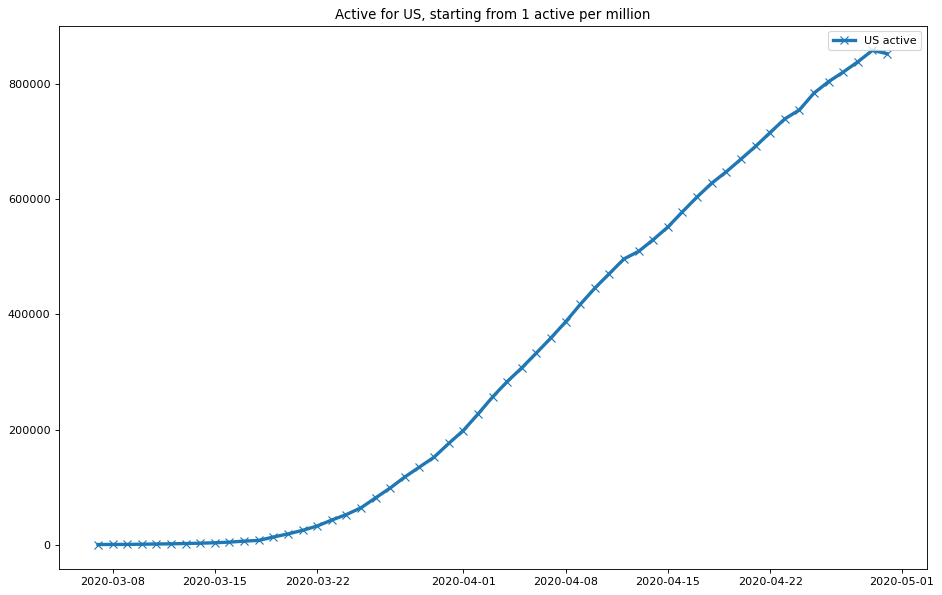

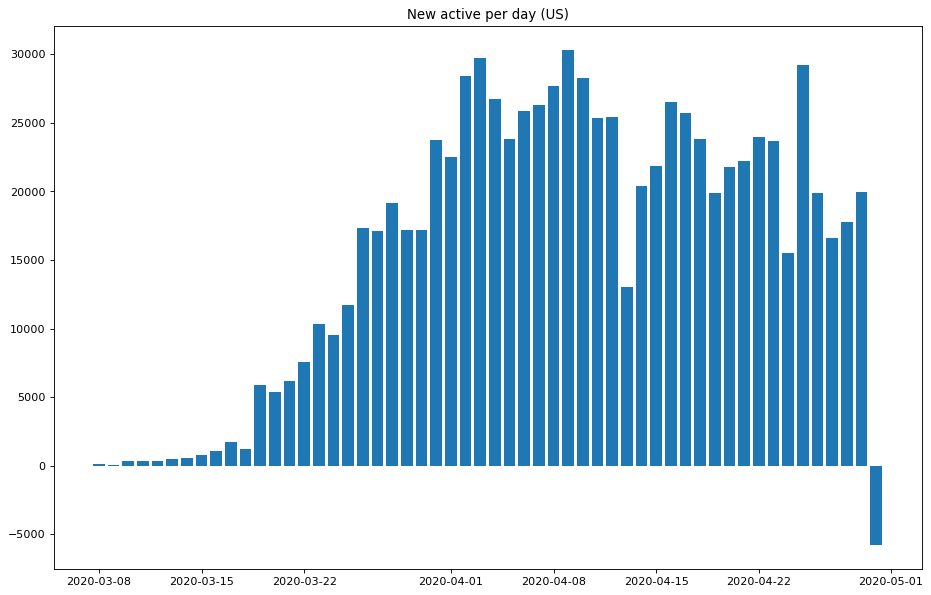

## United Kingdom

Population \\(67,886,011\\)

### Confirmed

Start date 2020-03-04 (1st day with 1 confirmed per million)

Latest number \\(172,481\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

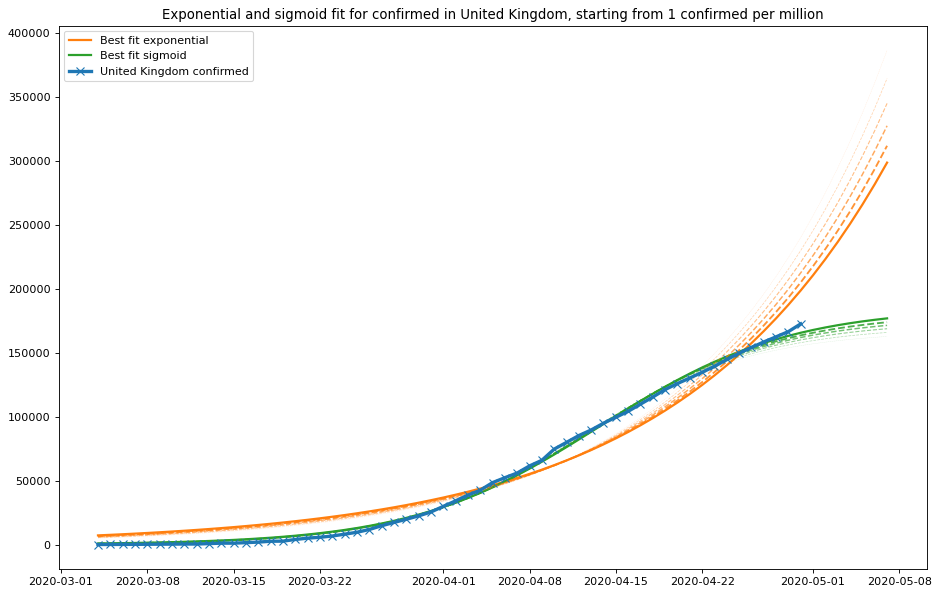

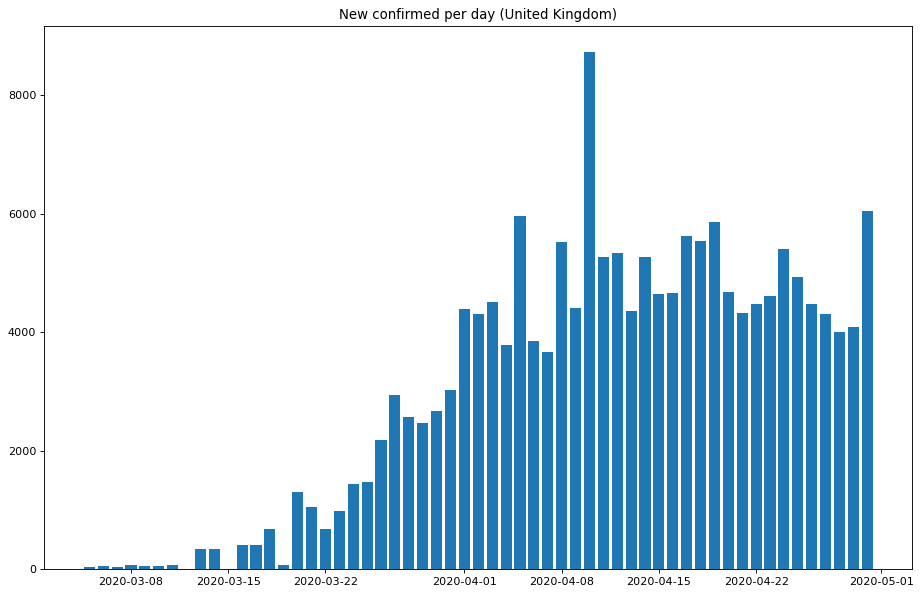

### Dead

Start date 2020-03-10 (1st day with 0.1 dead per million)

Latest number \\(26,842\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

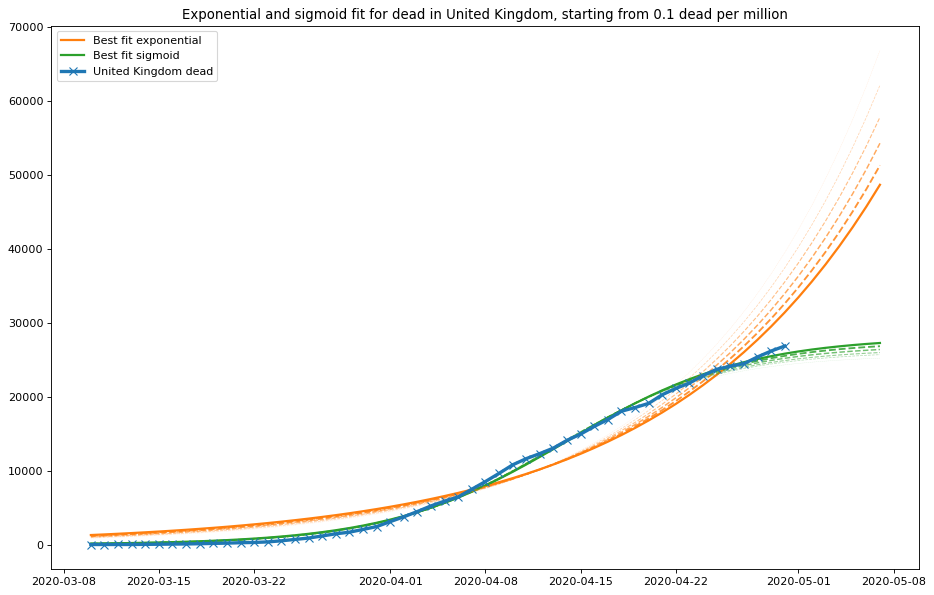

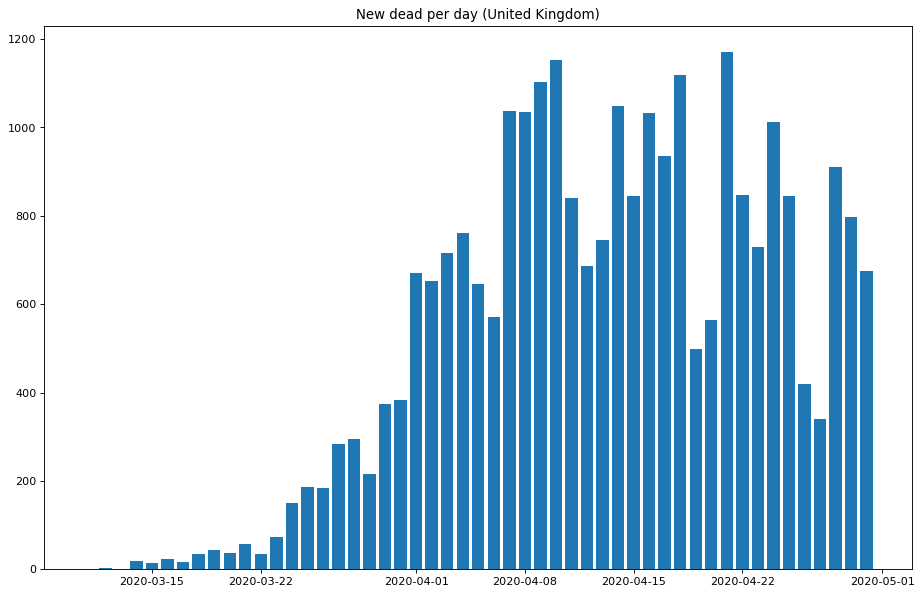

### Active

Start date 2020-03-04 (1st day with 1 active per million)

Latest number \\(144,780\\) on 2020-04-30

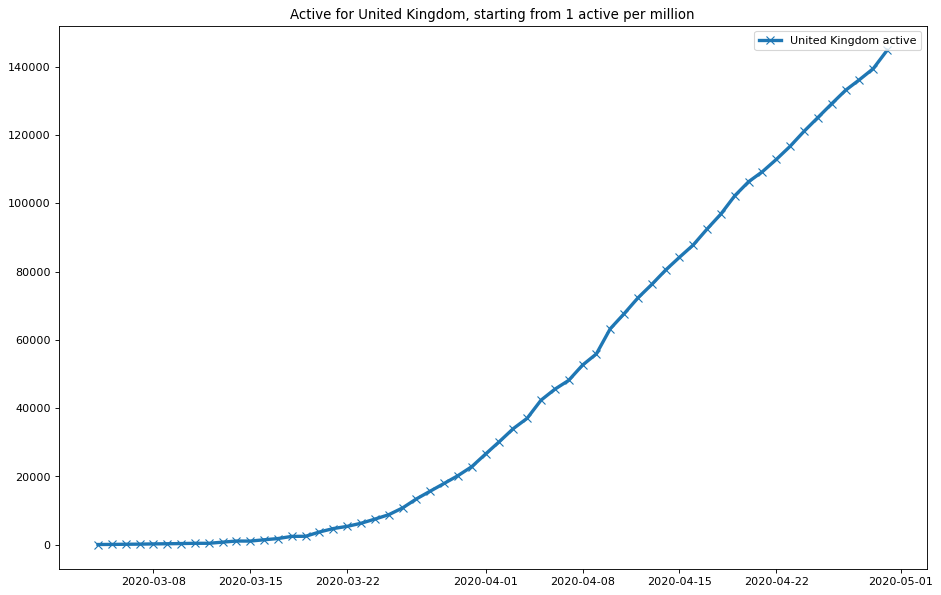

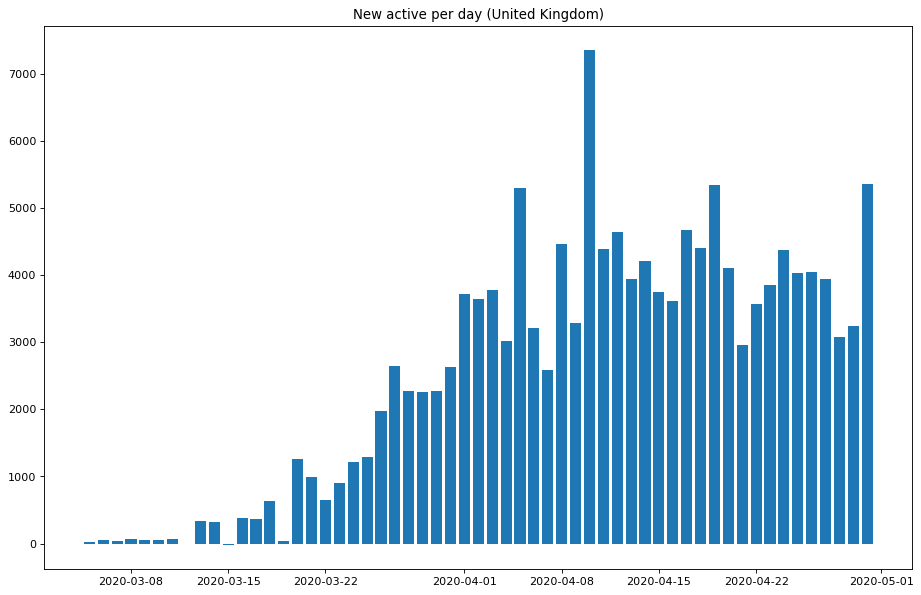

## Sweden

Population \\(10,099,265\\)

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(21,092\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

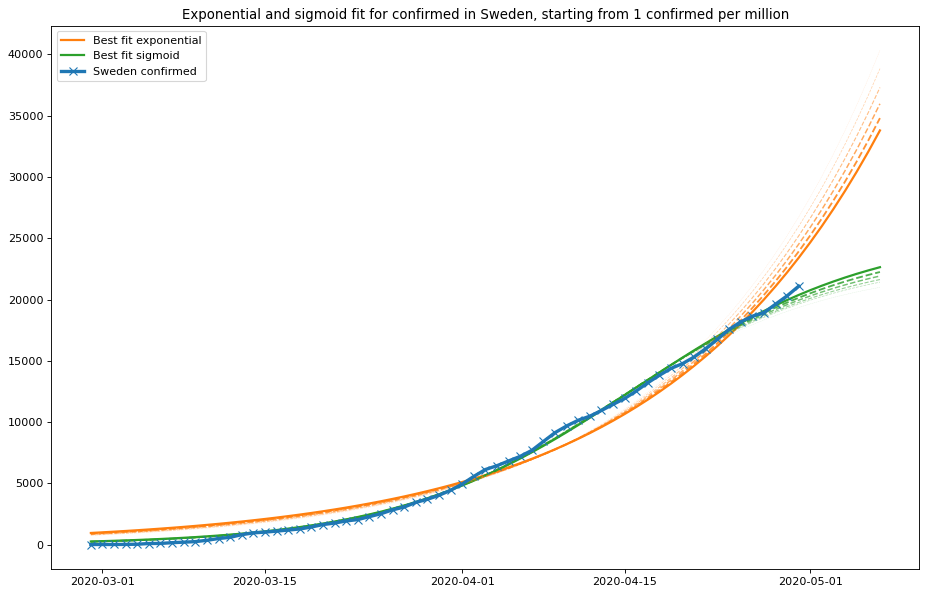

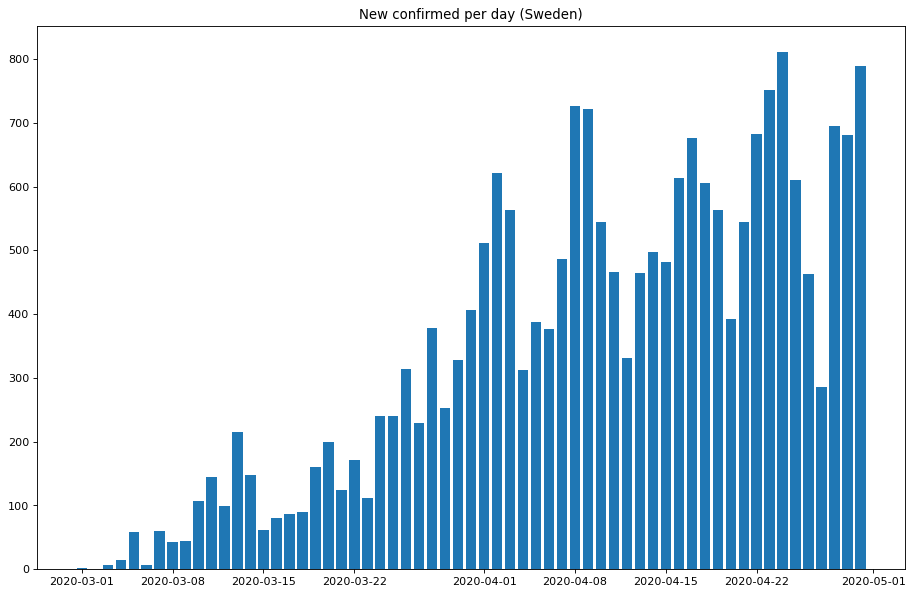

### Dead

Start date 2020-03-14 (1st day with 0.1 dead per million)

Latest number \\(2,586\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

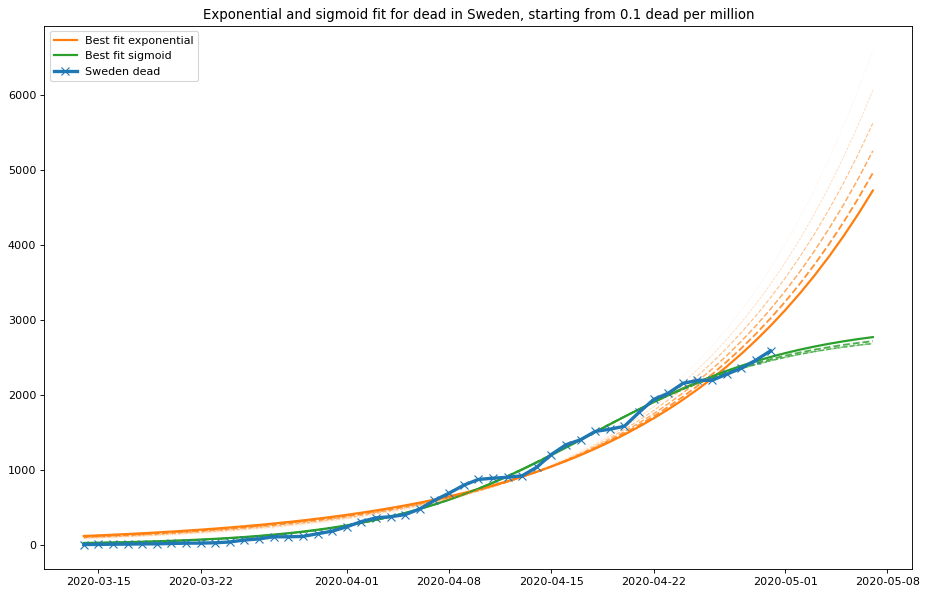

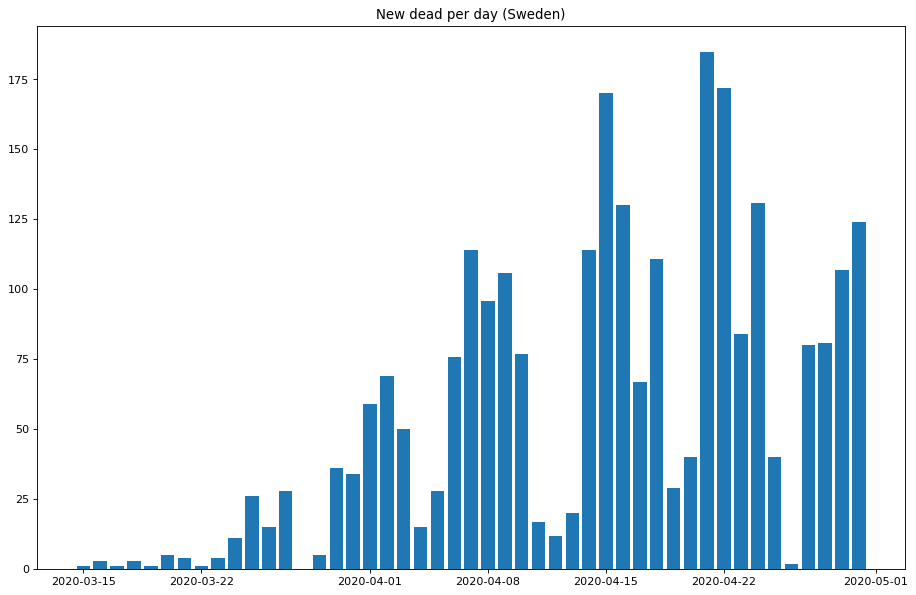

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(17,501\\) on 2020-04-30

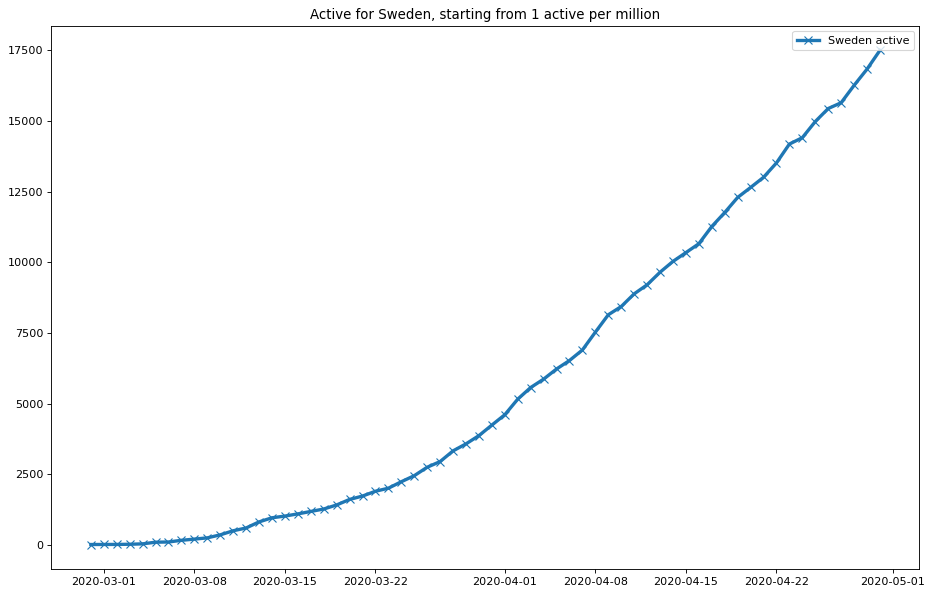

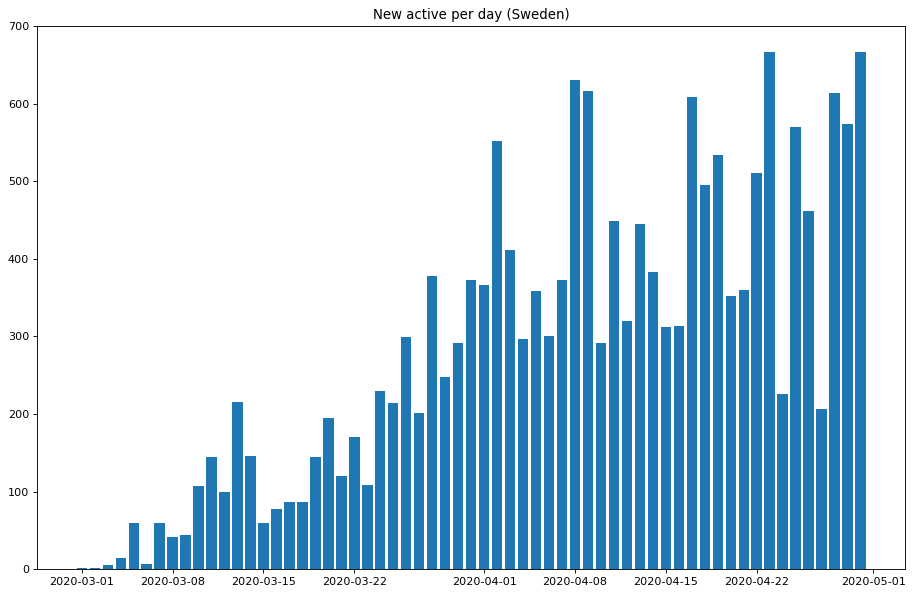

In [6]:
for country in countries_to_plot:
    country_deep_dive(country)

# Recovering countries that had over 300 active cases at peak

## List of all recovering countries (the top 4 not covered above are also analyzed below)

China recovered 99%
Iceland recovered 89%
Thailand recovered 85%
Luxembourg recovered 83%
Australia recovered 81%
Korea, South recovered 81%
Austria recovered 79%
New Zealand recovered 78%
Burkina Faso recovered 70%
Switzerland recovered 69%
Malta recovered 69%
Taiwan* recovered 68%
Iran recovered 61%
Germany recovered 55%
Niger recovered 54%
Andorra recovered 53%
Croatia recovered 48%
Djibouti recovered 46%
Azerbaijan recovered 46%
Denmark recovered 44%
Uzbekistan recovered 34%
Kyrgyzstan recovered 34%
Costa Rica recovered 34%
North Macedonia recovered 33%
Malaysia recovered 33%
Israel recovered 27%
Spain recovered 24%
Czechia recovered 23%
Slovakia recovered 17%
Turkey recovered 16%
Cuba recovered 11%
Italy recovered 6%


## China

Population \\(1,439,323,776\\)

### Confirmed

Start date 2020-01-26 (1st day with 1 confirmed per million)

Latest number \\(83,956\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

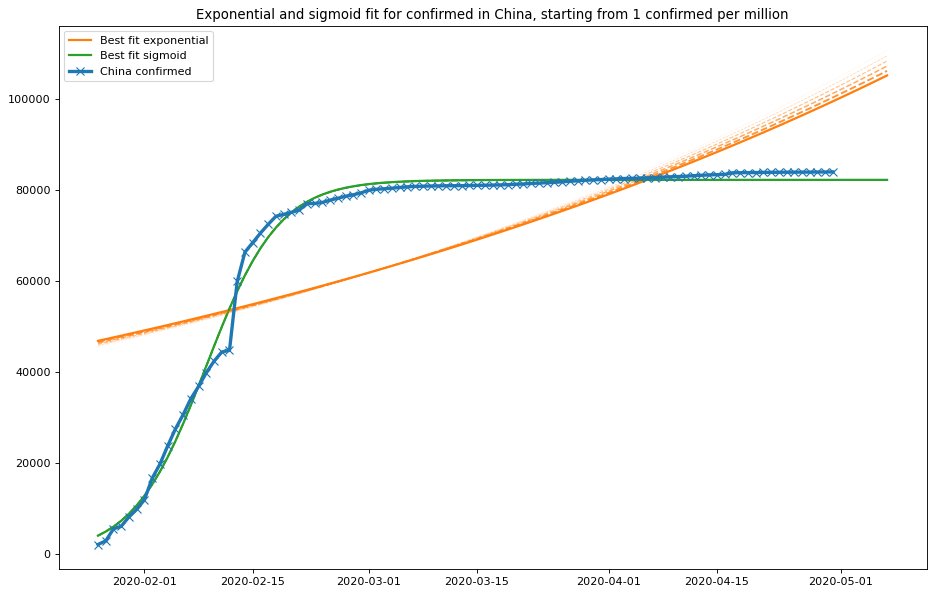

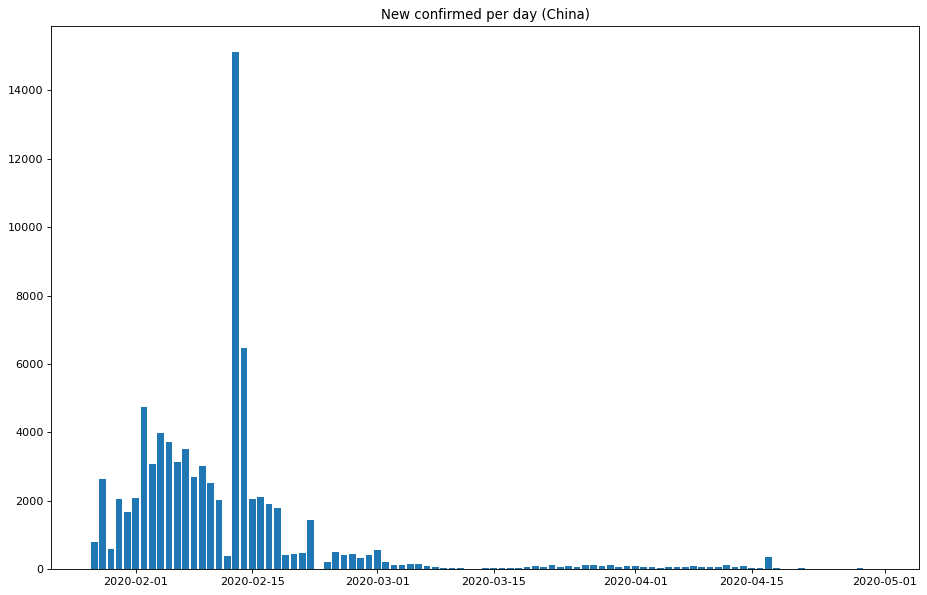

### Dead

Start date 2020-01-30 (1st day with 0.1 dead per million)

Latest number \\(4,637\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

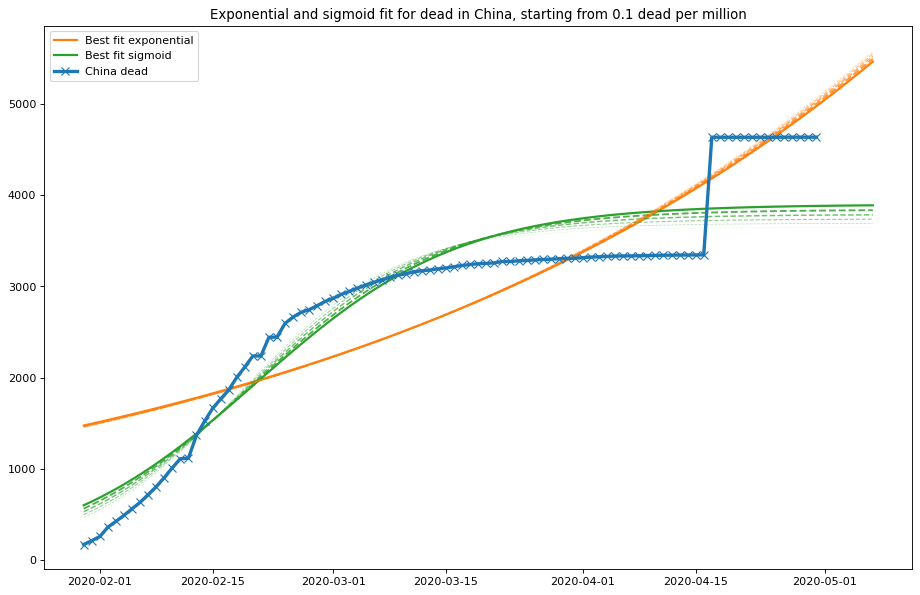

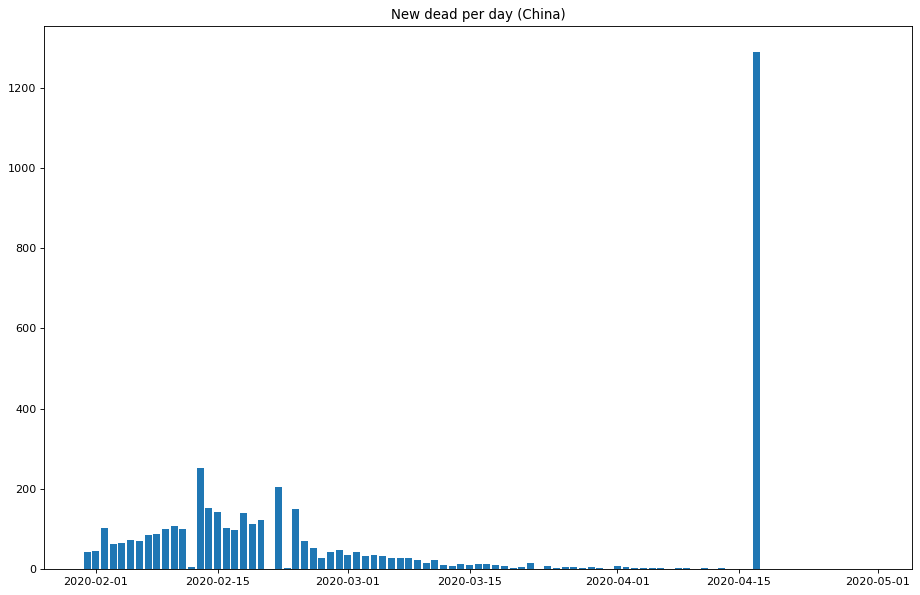

### Active

Start date 2020-01-26 (1st day with 1 active per million)

Latest number \\(796\\) on 2020-04-30

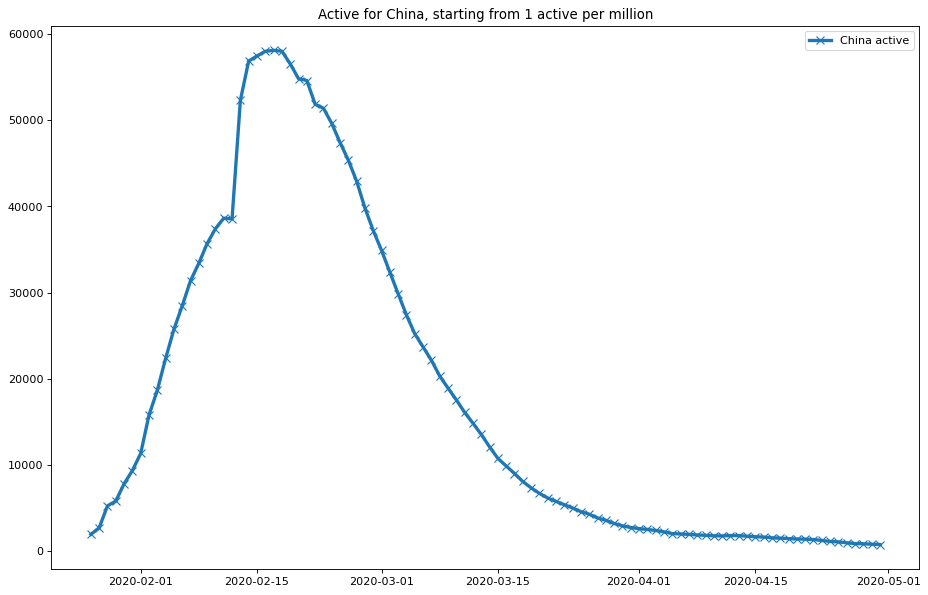

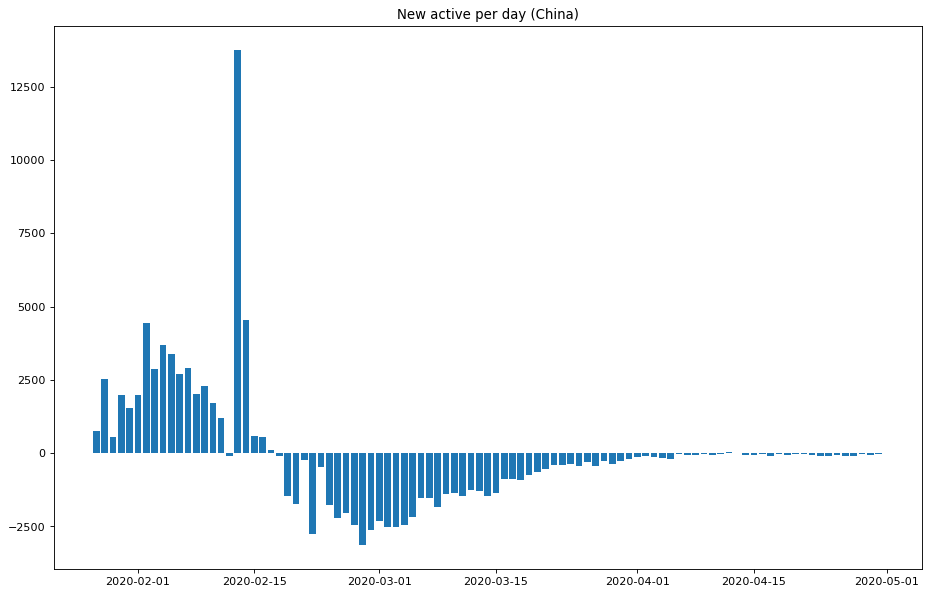

## Iceland

Population \\(341,243\\)

### Confirmed

Start date 2020-02-28 (1st day with 1 confirmed per million)

Latest number \\(1,797\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

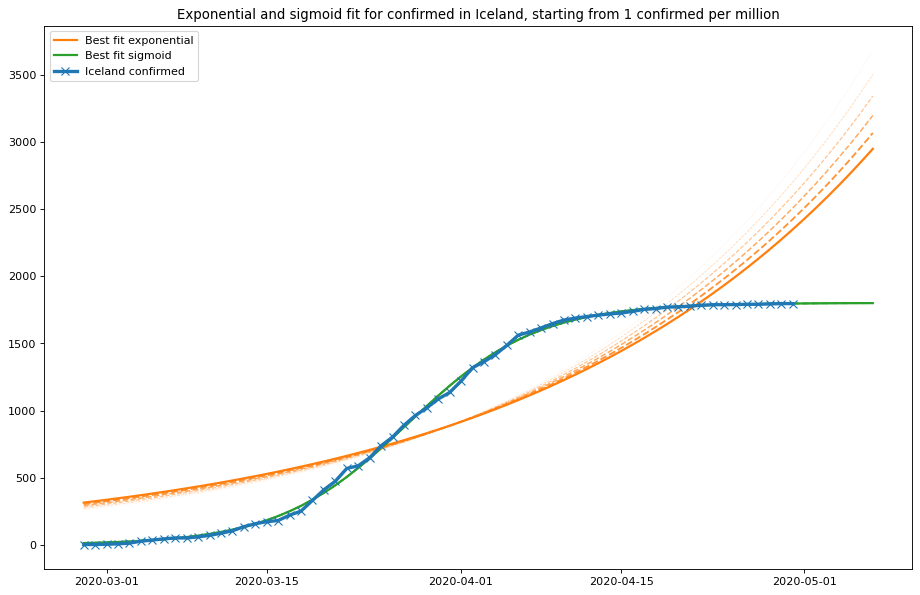

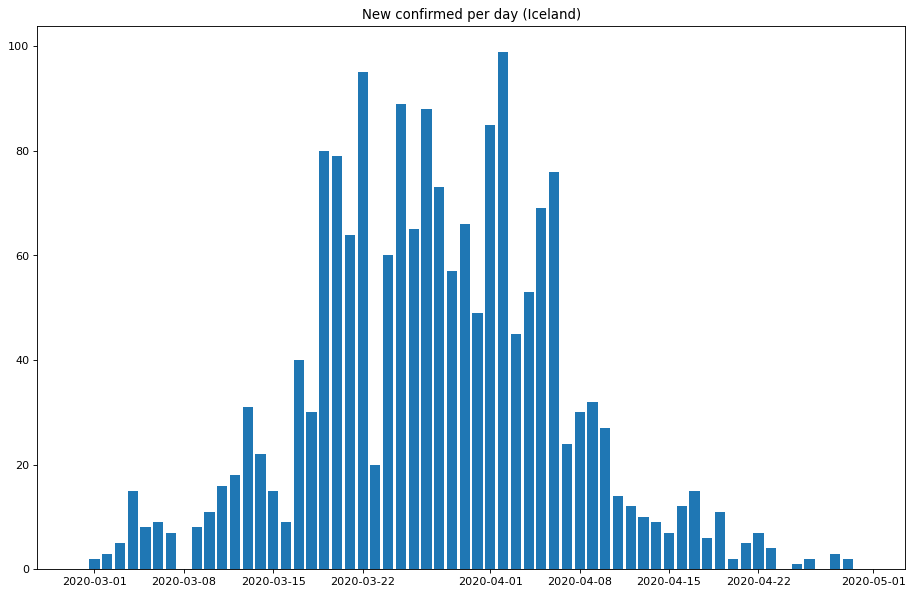

### Dead

Start date 2020-03-15 (1st day with 0.1 dead per million)

Latest number \\(10\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

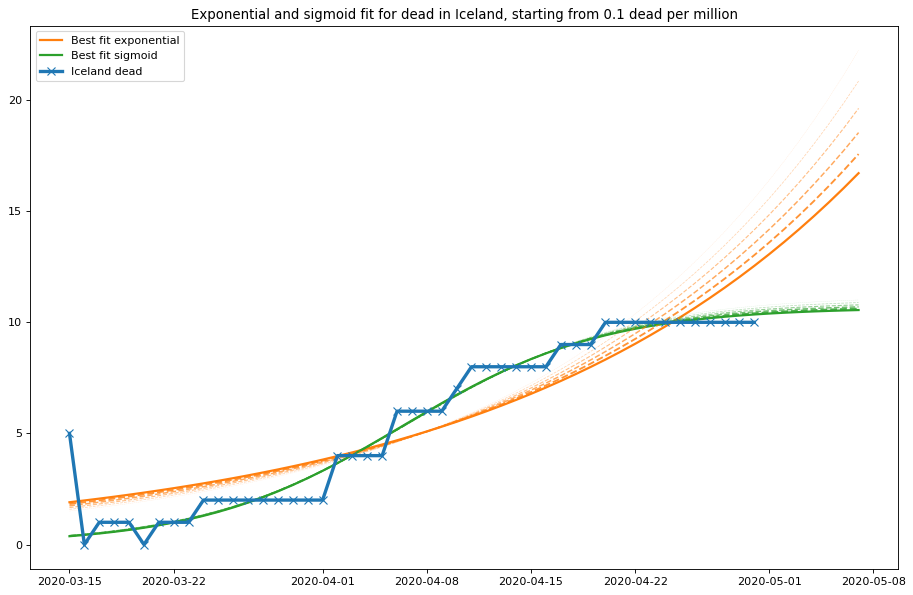

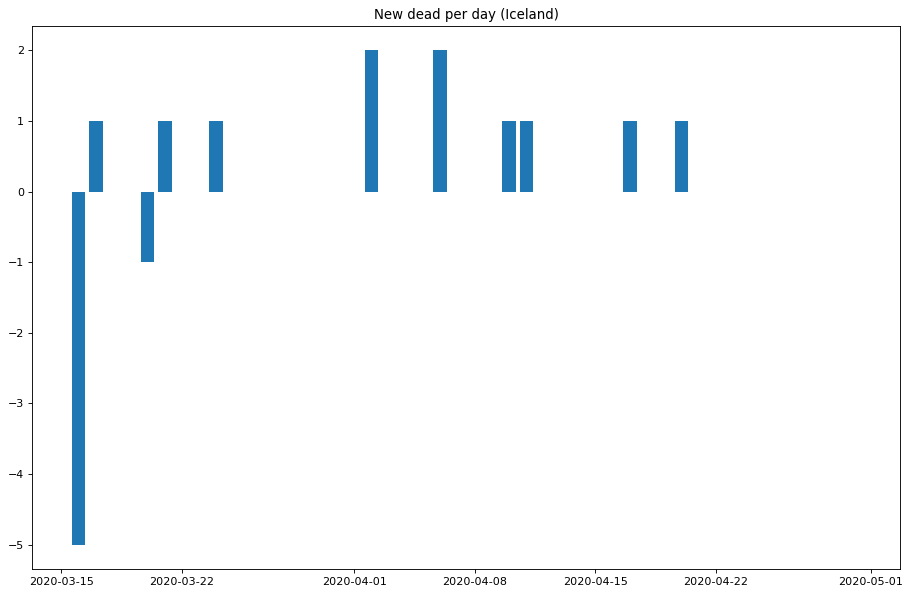

### Active

Start date 2020-02-28 (1st day with 1 active per million)

Latest number \\(117\\) on 2020-04-30

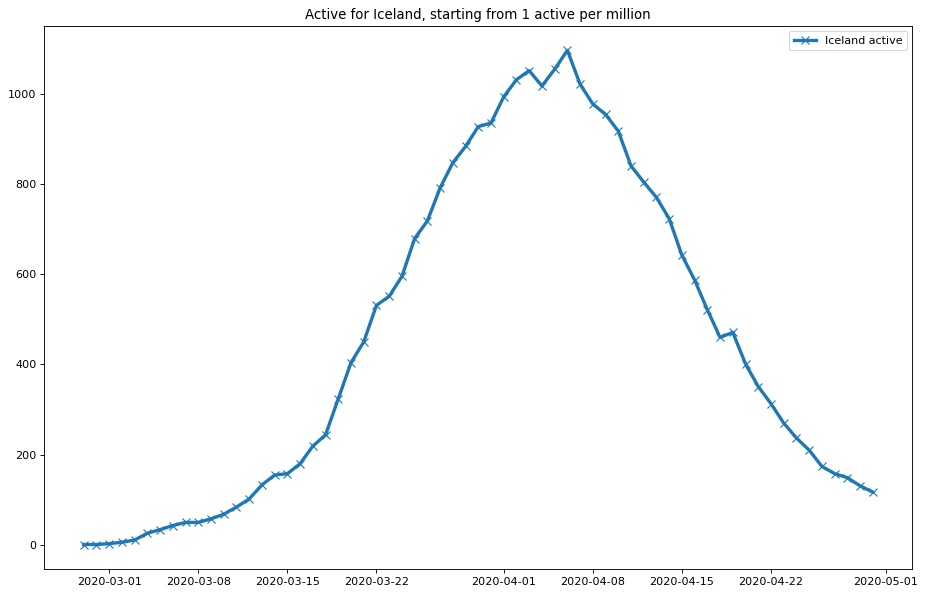

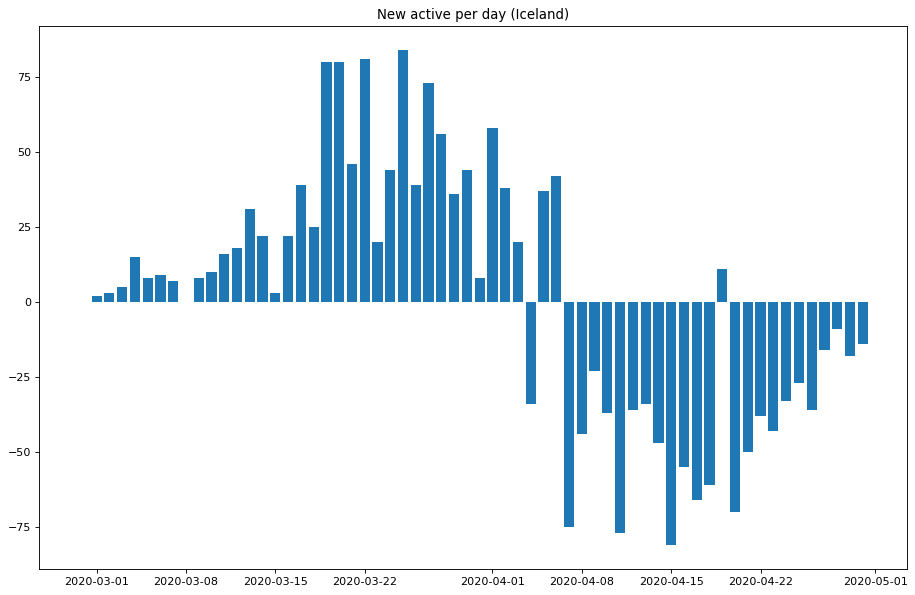

## Thailand

Population \\(69,799,978\\)

### Confirmed

Start date 2020-03-12 (1st day with 1 confirmed per million)

Latest number \\(2,954\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

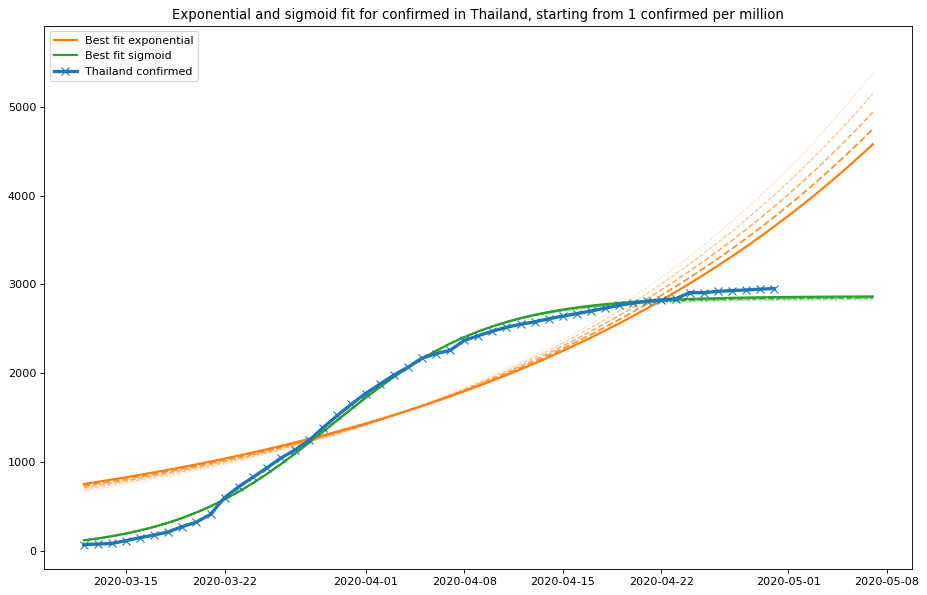

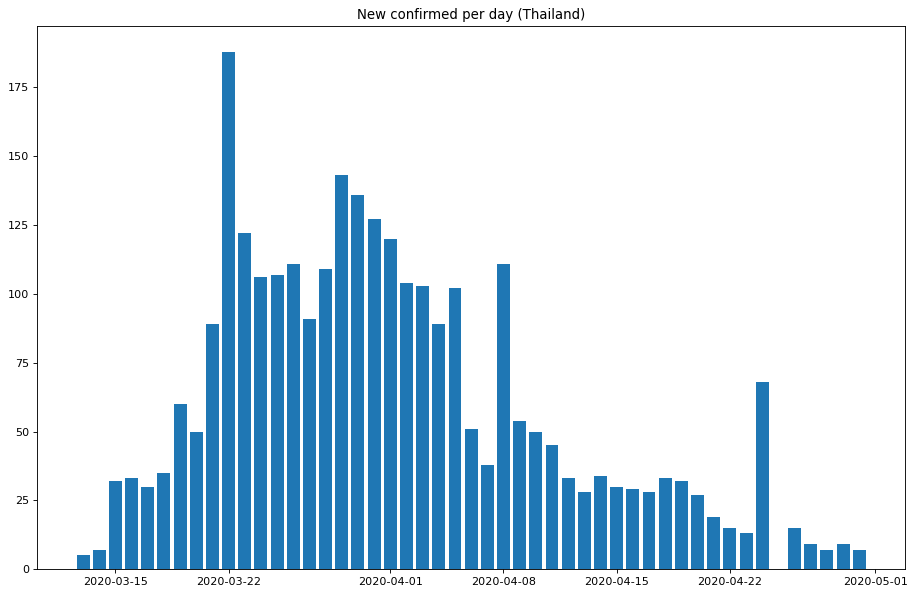

### Dead

Start date 2020-03-29 (1st day with 0.1 dead per million)

Latest number \\(54\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

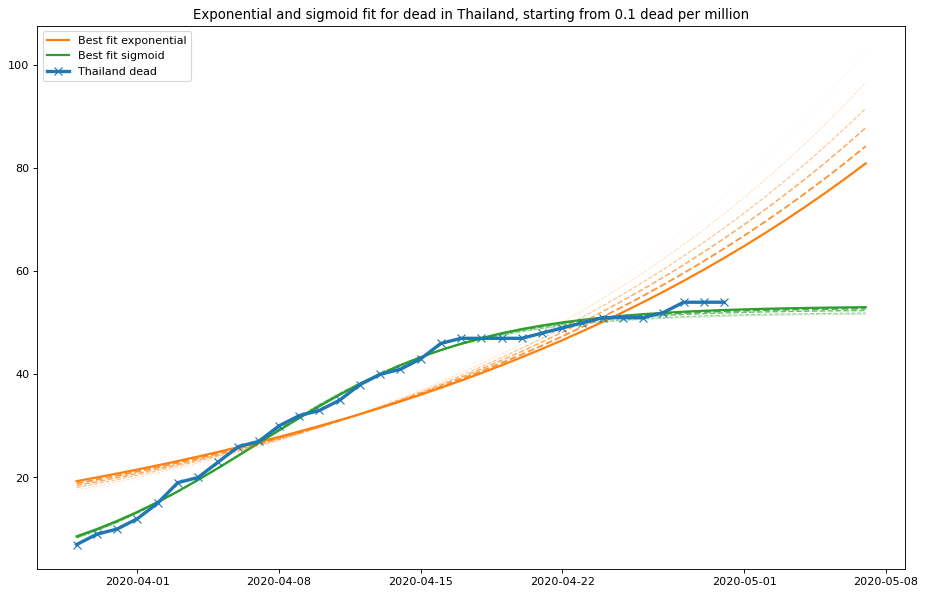

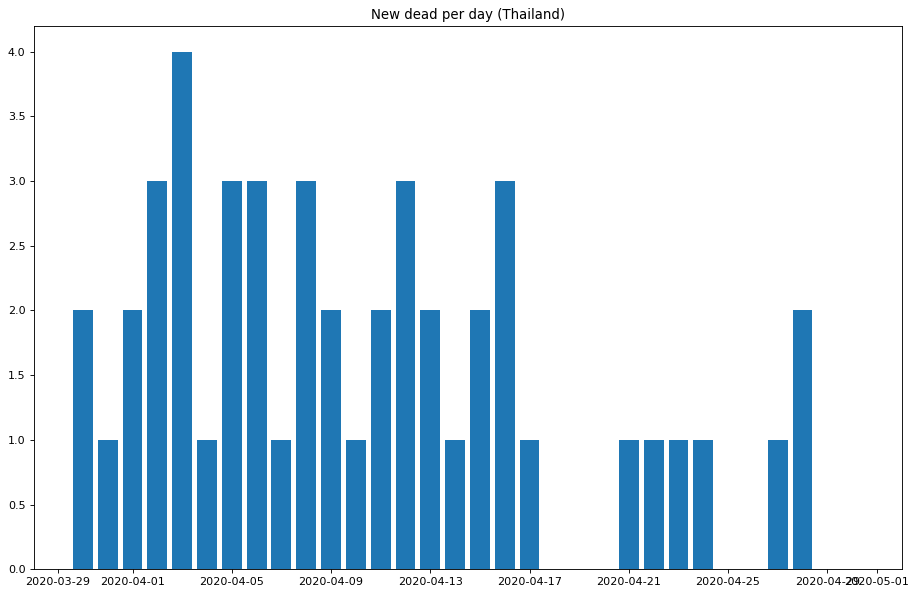

### Active

Start date 2020-03-15 (1st day with 1 active per million)

Latest number \\(216\\) on 2020-04-30

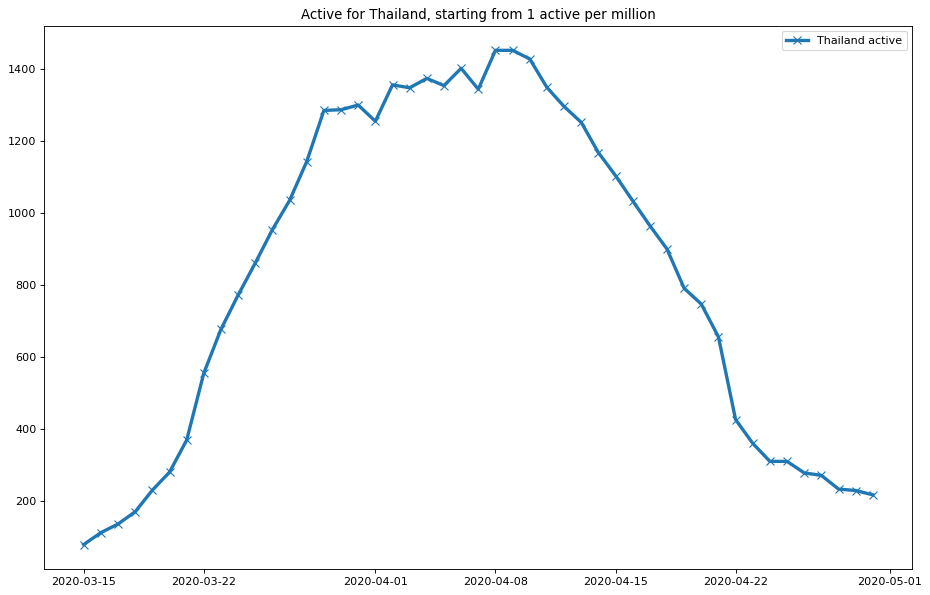

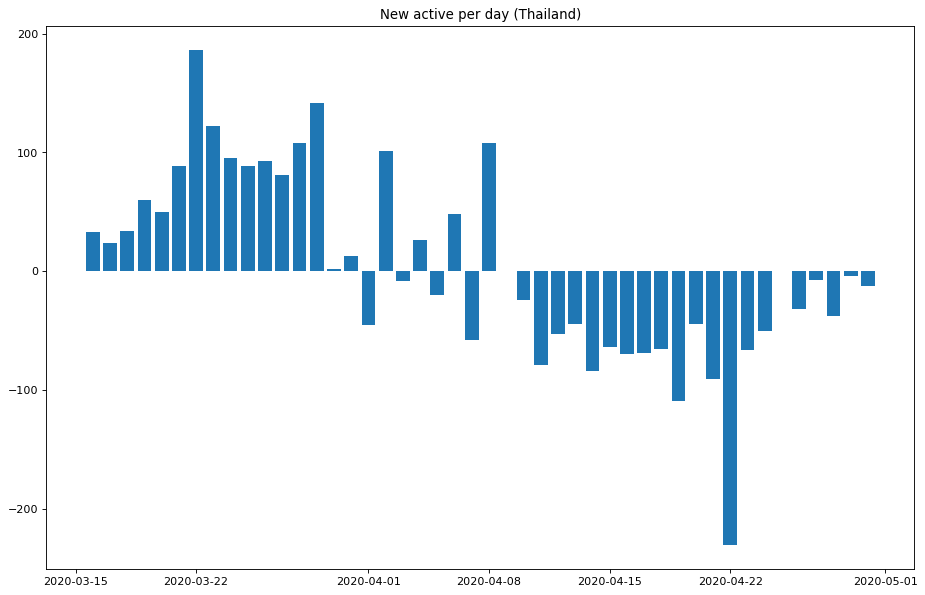

## Luxembourg

Population \\(625,978\\)

### Confirmed

Start date 2020-02-29 (1st day with 1 confirmed per million)

Latest number \\(3,784\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

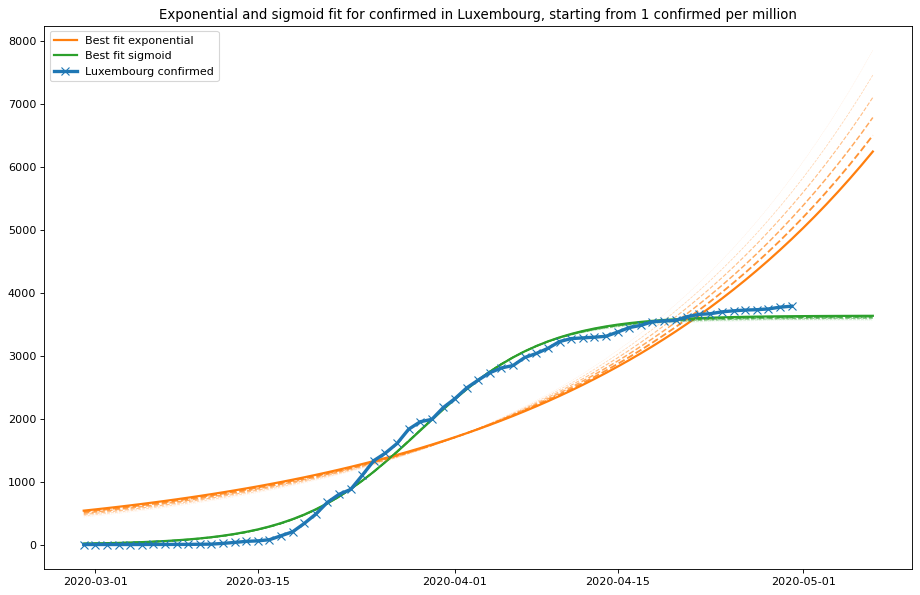

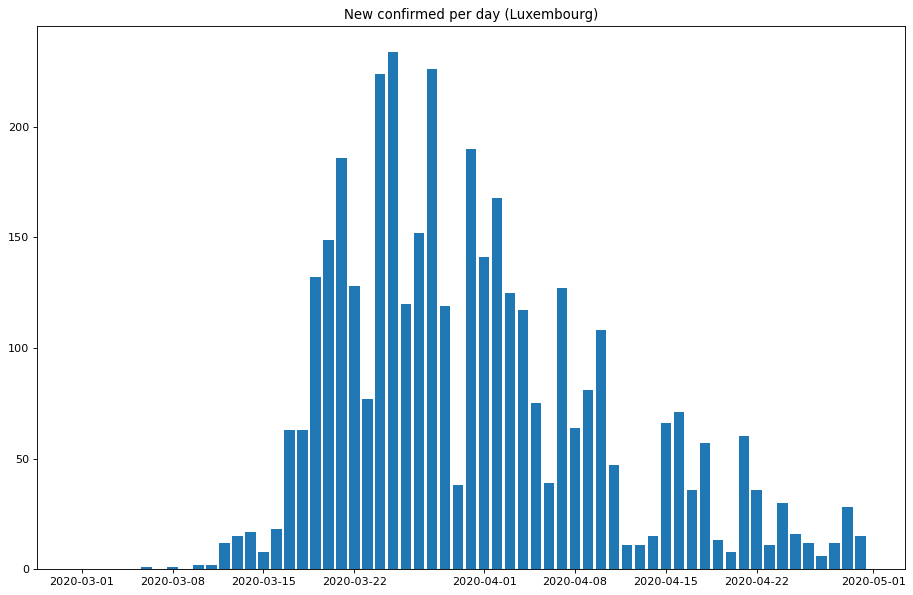

### Dead

Start date 2020-03-14 (1st day with 0.1 dead per million)

Latest number \\(90\\) on 2020-04-30

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

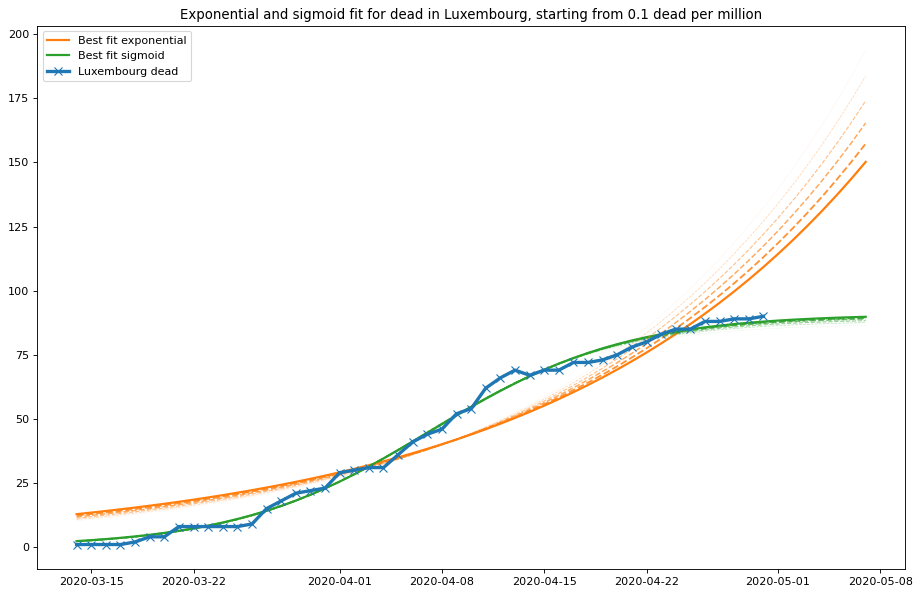

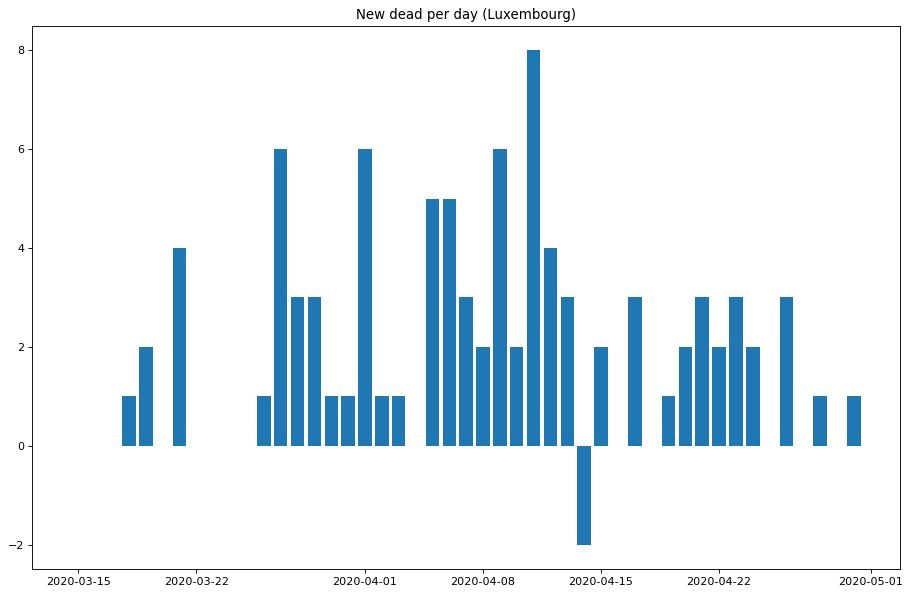

### Active

Start date 2020-02-29 (1st day with 1 active per million)

Latest number \\(481\\) on 2020-04-30

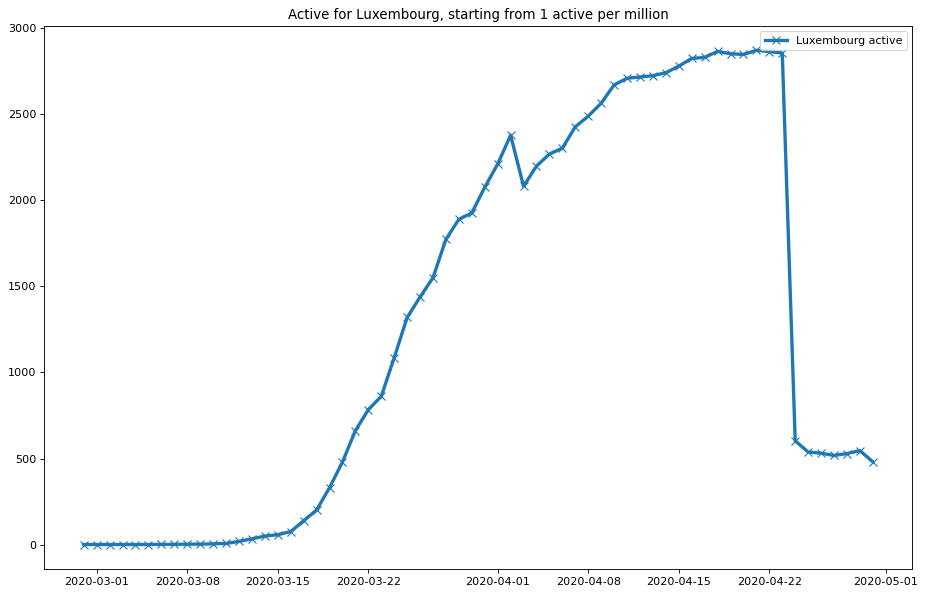

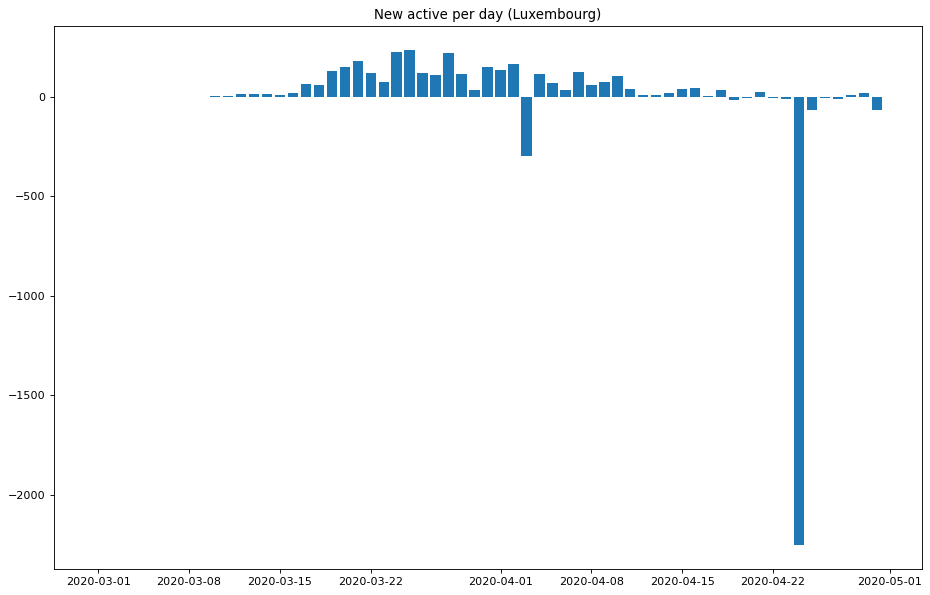

In [7]:
draw_recovering_countries(get_recovering_countries_info())